In [6]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
%matplotlib inline
path = '/Users/chrislam/Desktop/mastrangelo/data/'
# all data downloaded from Berger et al 2020's ancillary tables: https://arxiv.org/src/2001.07737v3/anc
# the paper we're comparing against: https://arxiv.org/pdf/2005.14671.pdf
# command line edit to get rid of double backslashes at end of each row: sed -e "s/\\\//g" GKSPCPapTable2_Final.txt > GKSPCPapTable2_cleaned.txt
table2 = pd.read_csv(path+'GKSPCPapTable2_cleaned.txt', sep='&', header=0)
print(len(table2))
print(table2.head())
print(table2.columns)

186301
      KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  iso_teff_err1  \
0  757076     1.396          0.179         -0.218    5052.2          103.9   
1  757099     0.873          0.054         -0.039    5364.9          102.7   
2  757137     1.669          0.309         -0.300    4628.7           84.8   
3  757280     1.715          0.086         -0.089    6856.8          144.4   
4  757450     0.914          0.062         -0.057    5301.2          111.0   

   iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  ...  iso_age  \
0          -86.6     3.373          0.067         -0.081  ...     2.47   
1          -84.9     4.318          0.037         -0.029  ...    15.20   
2          -76.2     2.388          0.083         -0.086  ...     1.51   
3         -139.9     3.834          0.033         -0.032  ...     1.24   
4         -103.1     4.432          0.045         -0.044  ...     9.46   

   unReAgeFlag  iso_age_err1  iso_age_err2  iso_dis  iso_dis_err1  \
0         

In [7]:
import matplotlib.pylab as pylab
pylab_params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(pylab_params)


In [8]:
# remove stars with unreliable ages or bad goodness of fit
table2 = table2.loc[(table2.unReAgeFlag.isnull()) & (table2.iso_gof==1.)]
print(len(table2))

150560


In [9]:
# remove stars with uninformative posteriors (per paper, terminal age of main sequence > 20 Gyr)
table2 = table2.loc[table2['TAMS']<=20]
print(len(table2))
# nice to see that tracks with bad gof or unreliable age

150560


In [10]:
# remove stars beyond [3700, 7500] K Teff, ie. keep only FGK stars
fgk = table2.loc[(table2['iso_teff'] <= 7500) & (table2['iso_teff'] >= 3700)]
print(len(fgk))

147900


In [11]:
# introduce Table 1 to use RUWE (re-normalized unit-weight error), aka binary star/edge-of-parameter space classifier
# command line edit to get rid of double backslashes at end of each row: sed -e "s/\\\//g" GKSPCPapTable1_Final.txt > GKSPCPapTable1_cleaned.txt
table1 = pd.read_csv(path+'GKSPCPapTable1_cleaned.txt', sep='&', header=0)
table1 = table1.loc[table1.RUWE<=1.2]
print(len(table1))
print(table1.head())
print(table1.columns)

164740
      KIC     gmag  gmag_err    kmag  kmag_err  parallax  parallax_err    feh  \
0  757076  12.3510    0.0203   9.559     0.017    1.5239        0.0483    NaN   
2  757137  10.0523    0.0279   6.722     0.017    1.7534        0.0253    NaN   
3  757280  12.1329    0.0200  10.627     0.018    1.2137        0.0220    NaN   
4  757450  15.8950    0.0202  13.118     0.029    1.1989        0.0261  0.229   
7  892010  12.6168    0.0209   9.041     0.017    0.5414        0.0242    NaN   

   feh_err    RUWE  num_gaia_companions Kmag_final_prov evstate  
0      NaN  0.9467                    0             NaN     NaN  
2      NaN  0.9126                    0             NaN     RGB  
3      NaN  0.8704                    0             NaN     NaN  
4     0.15  1.0300                    0             NaN     NaN  
7      NaN  1.0141                    0             NaN     NaN  
Index(['KIC', 'gmag', 'gmag_err', 'kmag', 'kmag_err', 'parallax',
       'parallax_err', 'feh', 'feh_err', 'RU

In [12]:
# join tables
catalog = pd.merge(fgk, table1, how='inner', on='KIC')
print(catalog.head())
print(len(catalog))

      KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  iso_teff_err1  \
0  757076     1.396          0.179         -0.218    5052.2          103.9   
1  757137     1.669          0.309         -0.300    4628.7           84.8   
2  757280     1.715          0.086         -0.089    6856.8          144.4   
3  757450     0.914          0.062         -0.057    5301.2          111.0   
4  892010     1.710          0.708         -0.402    4555.8          141.3   

   iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  ...    kmag  \
0          -86.6     3.373          0.067         -0.081  ...   9.559   
1          -76.2     2.388          0.083         -0.086  ...   6.722   
2         -139.9     3.834          0.033         -0.032  ...  10.627   
3         -103.1     4.432          0.045         -0.044  ...  13.118   
4          -92.4     2.299          0.163         -0.119  ...   9.041   

   kmag_err  parallax  parallax_err    feh  feh_err    RUWE  \
0     0.017    1.5239        

In [13]:
# isolate giant stars
# using unnumbered equation in first paragraph of Sec 4.2.1 ("Sample Selection") in Berger et al 2020b 
catalog['logR'] = np.log10(catalog.iso_rad)
catalog['is_giant'] = np.where(catalog['logR'] >= 0.00035*(catalog['iso_teff'] - 4500) + 0.15, True, False)
catalog = catalog.loc[catalog['is_giant'] == False]
print(len(catalog))
print(catalog.head())

112397
      KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  iso_teff_err1  \
2  757280     1.715          0.086         -0.089    6856.8          144.4   
3  757450     0.914          0.062         -0.057    5301.2          111.0   
6  892195     0.862          0.057         -0.040    5333.4          101.3   
7  892667     1.548          0.081         -0.087    6704.9          148.8   
8  892675     1.038          0.066         -0.076    5929.4          108.9   

   iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  ...  parallax  \
2         -139.9     3.834          0.033         -0.032  ...    1.2137   
3         -103.1     4.432          0.045         -0.044  ...    1.1989   
6          -84.2     4.372          0.039         -0.029  ...    2.0802   
7         -128.8     3.950          0.034         -0.036  ...    0.8512   
8         -108.1     4.385          0.035         -0.043  ...    1.7114   

   parallax_err    feh  feh_err    RUWE  num_gaia_companions  Kmag_final_

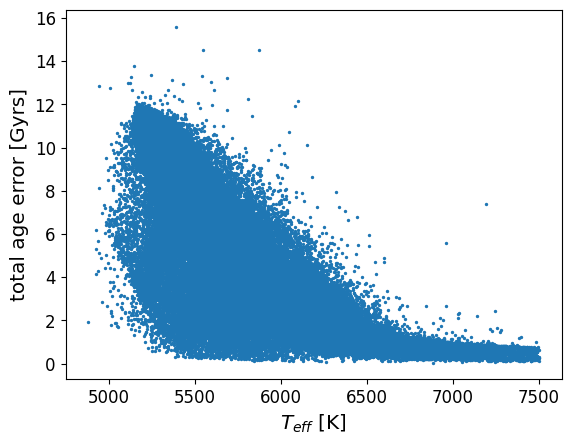

In [14]:
plt.scatter(catalog.iso_teff, np.abs(catalog.iso_age_err1)+np.abs(catalog.iso_age_err2), s=2)
plt.ylabel('total age error [Gyrs]')
plt.xlabel('$T_{eff}$ [K]')
plt.show()

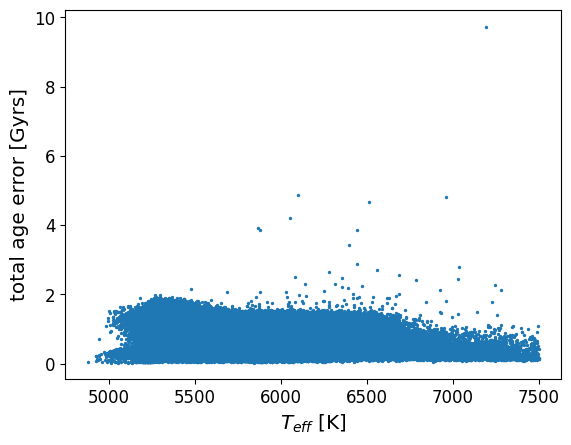

total:  67380
K dwarfs:  2873
percentage of K dwarfs in sample:  0.042638765212229146


In [15]:
# get rid of stars with fractional age errors greater than median age error [0.56 Gyrs]

catalog['fractional_err1'] = catalog.iso_age_err1/catalog.iso_age
catalog['fractional_err2'] = catalog.iso_age_err2/catalog.iso_age
plt.scatter(catalog.iso_teff, catalog.fractional_err1, s=2)
plt.ylabel('total age error [Gyrs]')
plt.xlabel('$T_{eff}$ [K]')
plt.show()

catalog = catalog.loc[catalog.fractional_err1 <= 0.56]
catalog = catalog.loc[np.abs(catalog.fractional_err2) <= 0.56]
print("total: ", len(catalog))
print("K dwarfs: ", len(catalog.loc[catalog.iso_teff < 5300])) # how many of these are K dwarfs?
print("percentage of K dwarfs in sample: ", len(catalog.loc[catalog.iso_teff < 5300])/len(catalog))

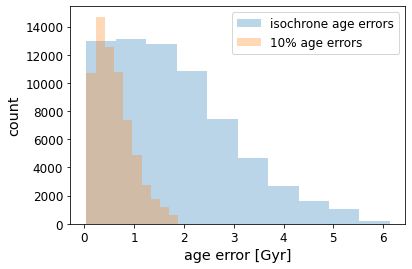

In [116]:
plt.hist(0.5*(catalog.iso_age_err1-catalog.iso_age_err2), alpha=0.3, label='isochrone age errors')
plt.hist(0.1*catalog.iso_age, alpha=0.3, label='10% age errors')
plt.legend()
plt.ylabel('count')
plt.xlabel('age error [Gyr]')
plt.show()

In [12]:
# young vs old fraction
print("stars younger than 1 Gyr: ", len(catalog.loc[catalog.iso_age <= 1]))
print("stars older than 1 Gyr: ", len(catalog.loc[catalog.iso_age > 1]))
print("percentage of sample younger than 1 Gyr: ", len(catalog.loc[catalog.iso_age <= 1])/len(catalog))
print("median age of sample: ", np.median(catalog.iso_age))

stars younger than 1 Gyr:  735
stars older than 1 Gyr:  66645
percentage of sample younger than 1 Gyr:  0.010908281389136243
median age of sample:  5.3


In [13]:
# catalog.to_csv('/Users/chris/Desktop/mastrangelo/data/berger_kepler_stellar_fgk.csv', index=False)


[   4   13   47  107  157  355  903 1264 1380 1479 1701 1929 2163 2549
 3124 3481 3842 4010 3938 3735 3568 3116 2893 2514 2418 1965 1752 1713
 1489 1325 1100  976  888  797  686  594  560  459  338  369  305  242
  223  183  183  130  136  110   92   75] [4879.6   4932.002 4984.404 5036.806 5089.208 5141.61  5194.012 5246.414
 5298.816 5351.218 5403.62  5456.022 5508.424 5560.826 5613.228 5665.63
 5718.032 5770.434 5822.836 5875.238 5927.64  5980.042 6032.444 6084.846
 6137.248 6189.65  6242.052 6294.454 6346.856 6399.258 6451.66  6504.062
 6556.464 6608.866 6661.268 6713.67  6766.072 6818.474 6870.876 6923.278
 6975.68  7028.082 7080.484 7132.886 7185.288 7237.69  7290.092 7342.494
 7394.896 7447.298 7499.7  ]


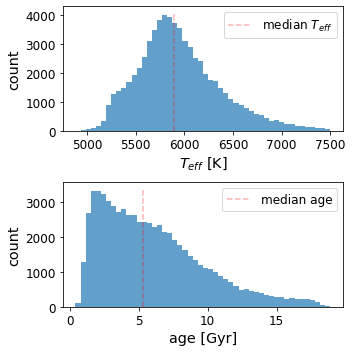

In [14]:
# teff histogram for all stars with well-constrained ages 
teff_hist, teff_bin_edges = np.histogram(catalog.iso_teff, bins=50)
print(teff_hist, teff_bin_edges)
#plt.bar(teff_bin_edges[:-1], teff_hist, width = 0.3)

fig, axes = plt.subplots(figsize=(5,5))
ax1 = plt.subplot2grid((2,1), (0,0))
ax1.hist(catalog.iso_teff, bins=50, alpha=0.7)
ax1.set_ylabel("count")
ax1.set_xlabel(r"$T_{eff}$ [K]")
# plot vertical red line through median Teff
ax1.plot([np.median(catalog.iso_teff), np.median(catalog.iso_teff)], 
         [0,4100], color='r', alpha=0.3, linestyle='--', label=r'median $T_{eff}$')
ax1.legend()

ax2 = plt.subplot2grid((2,1), (1,0))
ax2.hist(catalog.iso_age, bins=50, alpha=0.7)
# plot vertical red line through median age 
ax2.plot([np.median(catalog.iso_age), np.median(catalog.iso_age)], 
         [0,3400], color='r', alpha=0.3, linestyle='--', label='median age')
ax2.set_ylabel("count")
ax2.set_xlabel("age [Gyr]")
ax2.legend()
fig.tight_layout()
#plt.savefig('/Users/chris/Desktop/mastrangelo/figures/sample_properties.eps', format='eps')

plt.show()

Are asymmetric errors close enough to being treatable as Gaussian-distributed?

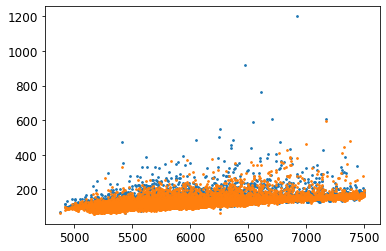

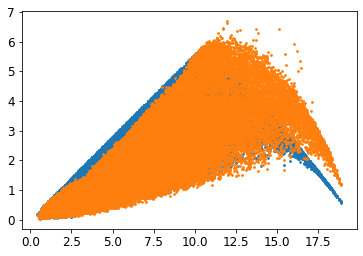

In [14]:
plt.scatter(catalog.iso_teff, catalog.iso_teff_err1, s=3)
plt.scatter(catalog.iso_teff, np.abs(catalog.iso_teff_err2), s=3)
plt.show()

plt.scatter(catalog.iso_age, catalog.iso_age_err1, s=3)
plt.scatter(catalog.iso_age, np.abs(catalog.iso_age_err2), s=3)
plt.show()

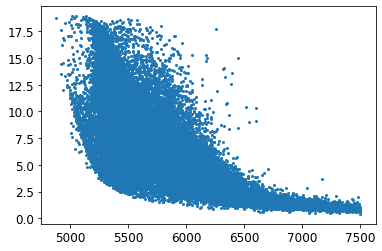

In [15]:
plt.scatter(catalog.iso_teff, catalog.iso_age, s=4)
plt.show()

I think we can get away with averaging the asymmetric errors and drawing them from a normal distribution.

In [15]:
catalog.iso_teff_err = 0.5 * (catalog.iso_teff_err1 + np.abs(catalog.iso_teff_err2))
catalog.iso_age_err = 0.5 * (catalog.iso_age_err1 + np.abs(catalog.iso_age_err2))

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


Split sample into F, G, and K dwarfs, as well as young, middle-aged, and old stars.

In [16]:
fdwarfs = catalog.loc[(catalog.iso_teff < 7500) & (catalog.iso_teff > 6000)]
gdwarfs = catalog.loc[(catalog.iso_teff < 6000) & (catalog.iso_teff > 5300)]
kdwarfs = catalog.loc[(catalog.iso_teff < 5300) & (catalog.iso_teff > 3700)]
print(len(fdwarfs), len(gdwarfs), len(kdwarfs))

young = catalog.loc[(catalog.iso_age < 3) & (catalog.iso_age > 0)]
middle = catalog.loc[(catalog.iso_age < 6) & (catalog.iso_age > 3)]
old = catalog.loc[(catalog.iso_age < 9) & (catalog.iso_age > 6)]
ancient = catalog.loc[(catalog.iso_age > 9)]

print(len(young), len(middle), len(old), len(ancient))

26441 38056 2873
17009 21123 15661 13416


#### Metallicity among stars in our sample

Bin by metallicity, in order to see if/how metallicity varies jointly with age and stellar type

In [17]:
feh_bins = np.linspace(-1, 1, 25)
feh_bins

array([-1.        , -0.91666667, -0.83333333, -0.75      , -0.66666667,
       -0.58333333, -0.5       , -0.41666667, -0.33333333, -0.25      ,
       -0.16666667, -0.08333333,  0.        ,  0.08333333,  0.16666667,
        0.25      ,  0.33333333,  0.41666667,  0.5       ,  0.58333333,
        0.66666667,  0.75      ,  0.83333333,  0.91666667,  1.        ])

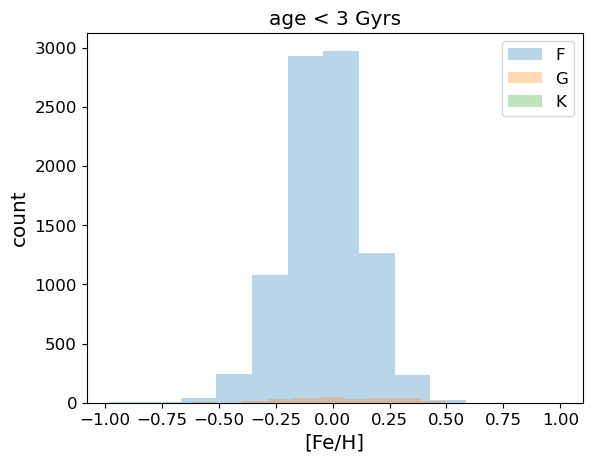

In [19]:
plt.hist(pd.merge(young, fdwarfs).feh, alpha=0.3, label='F')
plt.hist(pd.merge(young, gdwarfs).feh, alpha=0.3, label='G')
plt.hist(pd.merge(young, kdwarfs).feh, alpha=0.3, label='K')

plt.title('age < 3 Gyrs')
plt.ylabel('count')
plt.xlabel('[Fe/H]')
plt.legend()
plt.show()

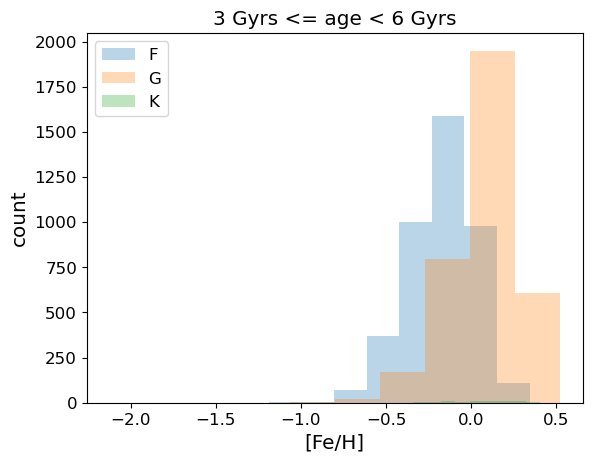

In [20]:
plt.hist(pd.merge(middle, fdwarfs).feh, alpha=0.3, label='F')
plt.hist(pd.merge(middle, gdwarfs).feh, alpha=0.3, label='G')
plt.hist(pd.merge(middle, kdwarfs).feh, alpha=0.3, label='K')

plt.title('3 Gyrs <= age < 6 Gyrs')
plt.ylabel('count')
plt.xlabel('[Fe/H]')
plt.legend()
plt.show()

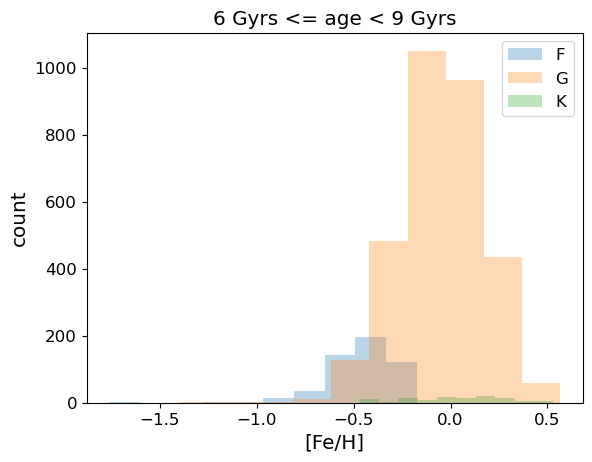

In [21]:
plt.hist(pd.merge(old, fdwarfs).feh, alpha=0.3, label='F')
plt.hist(pd.merge(old, gdwarfs).feh, alpha=0.3, label='G')
plt.hist(pd.merge(old, kdwarfs).feh, alpha=0.3, label='K')

plt.title('6 Gyrs <= age < 9 Gyrs')
plt.ylabel('count')
plt.xlabel('[Fe/H]')
plt.legend()
plt.show()

Same analysis, but bootstrapped over age, Teff, and metallicity errors

In [20]:
young_f = []
middle_f = []
old_f = []
young_g = []
middle_g = []
old_g = []
young_k = []
middle_k = []
old_k = []

for i in range(10):
    
    # instantiate dataframe that will go away after creating a histogram
    catalog_temp = pd.DataFrame()
    
    # sample Teff, age, and metallicity values, assuming normally distributed errors
    catalog_temp['teff'] = np.random.normal(catalog.iso_teff, catalog.iso_teff_err)
    catalog_temp['age'] = np.random.normal(catalog.iso_age, catalog.iso_age_err)
    catalog_temp['feh'] = np.random.normal(catalog.feh, catalog.feh_err)
    
    # classify F, G, K dwarfs
    fdwarfs_temp = catalog_temp.loc[(catalog_temp.teff < 7500) & (catalog_temp.teff > 6000)]
    gdwarfs_temp = catalog_temp.loc[(catalog_temp.teff < 6000) & (catalog_temp.teff > 5300)]
    kdwarfs_temp = catalog_temp.loc[(catalog_temp.teff < 5300) & (catalog_temp.teff > 3700)]
    
    # classify young, middle-aged, old stars
    young_temp = catalog_temp.loc[catalog_temp.age < 3]
    middle_temp = catalog_temp.loc[(catalog_temp.age >= 3) & (catalog_temp.age < 6)]
    old_temp = catalog_temp.loc[(catalog_temp.age >= 6) & (catalog_temp.age < 9)]
    
    # merge
    young_f_temp = pd.merge(fdwarfs_temp, young_temp)[['age', 'teff', 'feh']]
    middle_f_temp = pd.merge(fdwarfs_temp, middle_temp)[['age', 'teff', 'feh']]
    old_f_temp = pd.merge(fdwarfs_temp, old_temp)[['age', 'teff', 'feh']]

    young_g_temp = pd.merge(gdwarfs_temp, young_temp)[['age', 'teff', 'feh']]
    middle_g_temp = pd.merge(gdwarfs_temp, middle_temp)[['age', 'teff', 'feh']]
    old_g_temp = pd.merge(gdwarfs_temp, old_temp)[['age', 'teff', 'feh']]

    young_k_temp = pd.merge(kdwarfs_temp, young_temp)[['age', 'teff', 'feh']]
    middle_k_temp = pd.merge(kdwarfs_temp, middle_temp)[['age', 'teff', 'feh']]
    old_k_temp = pd.merge(kdwarfs_temp, old_temp)[['age', 'teff', 'feh']]
    
    # collect for histograms
    young_f.append(np.histogram(young_f_temp.dropna(), bins=feh_bins)[0])
    middle_f.append(np.histogram(middle_f_temp.dropna(), bins=feh_bins)[0])
    old_f.append(np.histogram(old_f_temp.dropna(), bins=feh_bins)[0])
    
    young_g.append(np.histogram(young_g_temp.dropna(), bins=feh_bins)[0])
    middle_g.append(np.histogram(middle_g_temp.dropna(), bins=feh_bins)[0])
    old_g.append(np.histogram(old_g_temp.dropna(), bins=feh_bins)[0])
    
    young_k.append(np.histogram(young_k_temp.dropna(), bins=feh_bins)[0])
    middle_k.append(np.histogram(middle_k_temp.dropna(), bins=feh_bins)[0])
    old_k.append(np.histogram(old_k_temp.dropna(), bins=feh_bins)[0])


Get maximum and minimum histograms for each bin, and normalize to sample size in order to more easily compare histogram peak positions

In [23]:
feh_mins = []
feh_maxes = []
young_f_mins = []
young_g_mins = []
young_k_mins = []
middle_f_mins = []
middle_g_mins = []
middle_k_mins = []
old_f_mins = []
old_g_mins = []
old_k_mins = []
young_f_maxes = []
young_g_maxes = []
young_k_maxes = []
middle_f_maxes = []
middle_g_maxes = []
middle_k_maxes = []
old_f_maxes = []
old_g_maxes = []
old_k_maxes = []

for i in range(len(feh_bins[:-1])):
    
    # F dwarfs
    young_f_mins.append(np.amin(np.take(young_f, indices=i, axis=1))/np.sum(young_f[np.argmin(np.take(young_f, indices=i, axis=1))]))
    young_f_maxes.append(np.amax(np.take(young_f, indices=i, axis=1))/np.sum(young_f[np.argmax(np.take(young_f, indices=i, axis=1))]))
    
    middle_f_mins.append(np.amin(np.take(middle_f, indices=i, axis=1))/np.sum(middle_f[np.argmin(np.take(middle_f, indices=i, axis=1))]))
    middle_f_maxes.append(np.amax(np.take(middle_f, indices=i, axis=1))/np.sum(middle_f[np.argmax(np.take(middle_f, indices=i, axis=1))]))
    
    old_f_mins.append(np.amin(np.take(old_f, indices=i, axis=1))/np.sum(old_f[np.argmin(np.take(old_f, indices=i, axis=1))]))
    old_f_maxes.append(np.amax(np.take(old_f, indices=i, axis=1))/np.sum(old_f[np.argmax(np.take(old_f, indices=i, axis=1))]))
    
    # G dwarfs
    young_g_mins.append(np.amin(np.take(young_g, indices=i, axis=1))/np.sum(young_g[np.argmin(np.take(young_g, indices=i, axis=1))]))
    young_g_maxes.append(np.amax(np.take(young_g, indices=i, axis=1))/np.sum(young_g[np.argmax(np.take(young_g, indices=i, axis=1))]))
    
    middle_g_mins.append(np.amin(np.take(middle_g, indices=i, axis=1))/np.sum(middle_g[np.argmin(np.take(middle_g, indices=i, axis=1))]))
    middle_g_maxes.append(np.amax(np.take(middle_g, indices=i, axis=1))/np.sum(middle_g[np.argmax(np.take(middle_g, indices=i, axis=1))]))
    
    old_g_mins.append(np.amin(np.take(old_g, indices=i, axis=1))/np.sum(old_g[np.argmin(np.take(old_g, indices=i, axis=1))]))
    old_g_maxes.append(np.amax(np.take(old_g, indices=i, axis=1))/np.sum(old_g[np.argmax(np.take(old_g, indices=i, axis=1))]))
    
    # K dwarfs
    young_k_mins.append(np.amin(np.take(young_k, indices=i, axis=1))/np.sum(young_k[np.argmin(np.take(young_k, indices=i, axis=1))]))
    young_k_maxes.append(np.amax(np.take(young_k, indices=i, axis=1))/np.sum(young_k[np.argmax(np.take(young_k, indices=i, axis=1))]))
    
    middle_k_mins.append(np.amin(np.take(middle_k, indices=i, axis=1))/np.sum(middle_k[np.argmin(np.take(middle_k, indices=i, axis=1))]))
    middle_k_maxes.append(np.amax(np.take(middle_k, indices=i, axis=1))/np.sum(middle_k[np.argmax(np.take(middle_k, indices=i, axis=1))]))
    
    old_k_mins.append(np.amin(np.take(old_k, indices=i, axis=1))/np.sum(old_k[np.argmin(np.take(old_k, indices=i, axis=1))]))
    old_k_maxes.append(np.amax(np.take(old_k, indices=i, axis=1))/np.sum(old_k[np.argmax(np.take(old_k, indices=i, axis=1))]))

In [34]:
path = '/Users/chris/Desktop/mastrangelo/'

In [ ]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(10, 10), sharex=True)

ax1.plot(feh_bins[:-1], young_f_maxes, label=f'F: {int(np.sum(np.median(young_f, axis=0)))}')
ax1.plot(feh_bins[:-1], young_g_maxes, label=f'G: {int(np.sum(np.median(young_g, axis=0)))}')
ax1.plot(feh_bins[:-1], young_k_maxes, label=f'K: {int(np.sum(np.median(young_g, axis=0)))}')
ax1.set_title('age < 3 Gyrs; max')
ax1.set_ylabel('normalized count')
ax1.legend()

ax2.plot(feh_bins[:-1], young_f_mins)
ax2.plot(feh_bins[:-1], young_g_mins)
ax2.plot(feh_bins[:-1], young_k_mins)
ax2.set_title('age < 3 Gyrs; min')

ax3.plot(feh_bins[:-1], middle_f_maxes, label=f'F: {int(np.sum(np.median(middle_f, axis=0)))}')
ax3.plot(feh_bins[:-1], middle_g_maxes, label=f'G: {int(np.sum(np.median(middle_g, axis=0)))}')
ax3.plot(feh_bins[:-1], middle_k_maxes, label=f'K: {int(np.sum(np.median(middle_k, axis=0)))}')
ax3.set_title('3 Gyrs <= age < 6 Gyrs; max')
ax3.set_ylabel('normalized count')
ax3.legend()

ax4.plot(feh_bins[:-1], young_f_mins)
ax4.plot(feh_bins[:-1], young_g_mins)
ax4.plot(feh_bins[:-1], young_k_mins)
ax4.set_title('3 Gyrs <= age < 6 Gyrs; min')

ax5.plot(feh_bins[:-1], middle_f_maxes, label=f'F: {int(np.sum(np.median(old_f, axis=0)))}')
ax5.plot(feh_bins[:-1], middle_g_maxes, label=f'G: {int(np.sum(np.median(old_g, axis=0)))}')
ax5.plot(feh_bins[:-1], middle_k_maxes, label=f'K: {int(np.sum(np.median(old_k, axis=0)))}')
ax5.set_title('age >= 6 Gyrs; max')
ax5.set_ylabel('normalized count')
ax5.set_xlabel('[Fe/H]')
ax5.legend()

ax6.plot(feh_bins[:-1], young_f_mins)
ax6.plot(feh_bins[:-1], young_g_mins)
ax6.plot(feh_bins[:-1], young_k_mins)
ax6.set_title('age >= 6 Gyrs; min')
ax6.set_xlabel('[Fe/H]')

plt.tight_layout()
plt.savefig(path+'figures/metallicity-type-age.pdf', format='pdf')
plt.show()

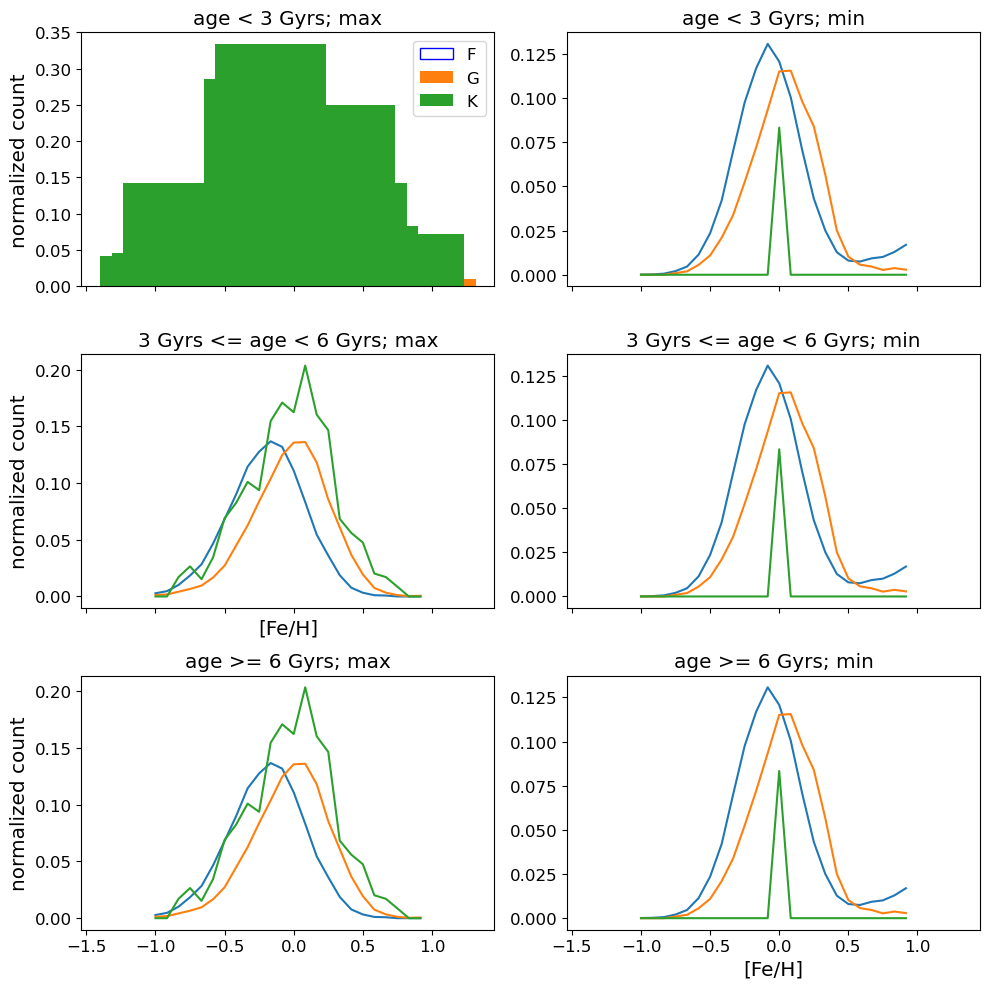

In [26]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(10, 10), sharex=True)

ax1.bar(feh_bins[:-1], young_f_maxes, label='F', edgecolor='blue', fill=False, 
        width=feh_bins[1]-feh_bins[0])
ax1.bar(feh_bins[:-1], young_g_maxes, label='G')
ax1.bar(feh_bins[:-1], young_k_maxes, label='K')
ax1.set_title('age < 3 Gyrs; max')
ax1.set_ylabel('normalized count')
ax1.legend()

ax2.plot(feh_bins[:-1], young_f_mins)
ax2.plot(feh_bins[:-1], young_g_mins)
ax2.plot(feh_bins[:-1], young_k_mins)
ax2.set_title('age < 3 Gyrs; min')

ax3.plot(feh_bins[:-1], middle_f_maxes)
ax3.plot(feh_bins[:-1], middle_g_maxes)
ax3.plot(feh_bins[:-1], middle_k_maxes)
ax3.set_title('3 Gyrs <= age < 6 Gyrs; max')
ax3.set_ylabel('normalized count')
ax3.set_xlabel('[Fe/H]')

ax4.plot(feh_bins[:-1], young_f_mins)
ax4.plot(feh_bins[:-1], young_g_mins)
ax4.plot(feh_bins[:-1], young_k_mins)
ax4.set_title('3 Gyrs <= age < 6 Gyrs; min')

ax5.plot(feh_bins[:-1], middle_f_maxes)
ax5.plot(feh_bins[:-1], middle_g_maxes)
ax5.plot(feh_bins[:-1], middle_k_maxes)
ax5.set_title('age >= 6 Gyrs; max')
ax5.set_ylabel('normalized count')

ax6.plot(feh_bins[:-1], young_f_mins)
ax6.plot(feh_bins[:-1], young_g_mins)
ax6.plot(feh_bins[:-1], young_k_mins)
ax6.set_title('age >= 6 Gyrs; min')
ax6.set_xlabel('[Fe/H]')

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


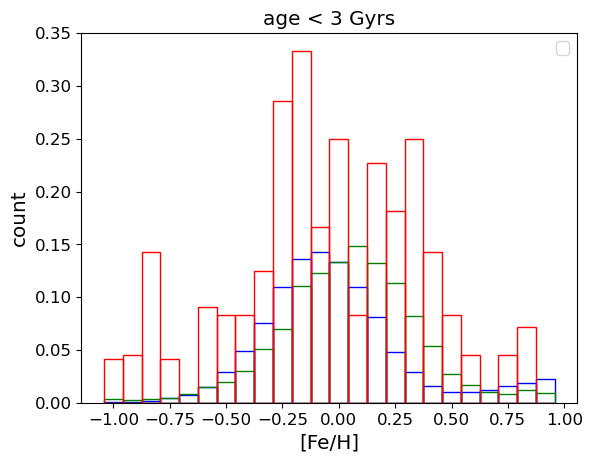

In [27]:
#plt.bar(feh_bins[:-1], young_f_mins, label='F', edgecolor='blue', linestyle='dashed', fill=False, 
#        width=feh_bins[1]-feh_bins[0])
plt.bar(feh_bins[:-1], young_f_maxes, edgecolor='blue', linestyle='solid', fill=False, 
        width=feh_bins[1]-feh_bins[0])
#plt.bar(feh_bins[:-1], young_g_mins, label='G', edgecolor='green', linestyle='dashed', fill=False, 
#        width=feh_bins[1]-feh_bins[0])
plt.bar(feh_bins[:-1], young_g_maxes, edgecolor='green', linestyle='solid', fill=False, 
        width=feh_bins[1]-feh_bins[0])
#plt.bar(feh_bins[:-1], young_k_mins, label='K', edgecolor='red', linestyle='dashed', fill=False, 
#        width=feh_bins[1]-feh_bins[0])
plt.bar(feh_bins[:-1], young_k_maxes, edgecolor='red', linestyle='solid', fill=False, 
        width=feh_bins[1]-feh_bins[0])
    
plt.title('age < 3 Gyrs')
plt.ylabel('count')
plt.xlabel('[Fe/H]')
plt.legend()
plt.show()

### Time to crossmatch

In [18]:
# source: https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative
path = '/Users/chris/Desktop/mastrangelo/data/'
kois = pd.read_csv(path+'cumulative_2021.03.04_20.04.43.csv')
kois = kois.loc[kois.koi_disposition != 'FALSE POSITIVE']
kois_score = kois.loc[kois.koi_score >= 0.5]
kois_fpp = pd.read_csv(path+'q1_q17_dr25_koifpp_2023.09.24_15.11.58.csv')
kois_fpp = kois_fpp.loc[kois_fpp.fpp_prob <= 0.5]
#print(kois)
#print(list(kois.columns))
print("KOI disposition: ", len(kois.kepid.unique()), len(kois.kepid))
print("KOI score: ", len(kois_score.kepid.unique()), len(kois_score.kepid))
print("KOI FPP: ", len(kois_fpp.kepid.unique()), len(kois_fpp.kepid))


KOI disposition:  3611 4724
KOI score:  2853 3802
KOI FPP:  3946 4886


In [129]:
### brief aside to produce stellar rotation periods and planet orbital periods for Natalia's art project
reinhold_rotation_periods = pd.read_csv('/Users/chris/Desktop/natalia-art/table.txt', sep=r"\s+")
periods = pd.merge(kois, reinhold_rotation_periods, how='inner', left_on='kepid', right_on='KIC') 
periods[['kepid', 'Prot', 'koi_period']].to_csv('/Users/chris/Desktop/natalia-art/crossmatch.txt', index=False)

In [19]:
positives_kepler = pd.merge(kois, catalog, how='inner', left_on='kepid', right_on='KIC') 
positives_kepler_score = pd.merge(kois_score, catalog, how='inner', left_on='kepid', right_on='KIC') 
positives_kepler_fpp = pd.merge(kois_fpp, catalog, how='inner', left_on='kepid', right_on='KIC') 

In [20]:
path = '/Users/chris/Desktop/mastrangelo/data/'
kepler_stellar = pd.read_csv(path+'kepler_stellar_17.csv')
print(len(kepler_stellar))
print(kepler_stellar.head())

200038
    kepid           tm_designation  teff  teff_err1  teff_err2   logg  \
0  757076  2MASS J19240929+3635532  5160      171.0     -156.0  3.580   
1  757099  2MASS J19241033+3635377  5519      182.0     -149.0  3.822   
2  757137  2MASS J19241341+3633358  4706       74.0     -102.0  2.374   
3  757280  2MASS J19242289+3633538  6543      162.0     -194.0  4.082   
4  757450  2MASS J19243302+3634385  5332      106.0      -96.0  4.500   

   logg_err1  logg_err2   feh  feh_err1  ...  timeout06p0  timeout07p5  \
0      0.928     -0.232 -0.10      0.30  ...          0.0          0.0   
1      0.638     -0.213 -0.22      0.35  ...          1.0          1.0   
2      0.030     -0.027 -0.10      0.20  ...          1.0          1.0   
3      0.258     -0.172 -0.24      0.25  ...          0.0          0.0   
4      0.050     -0.036 -0.08      0.15  ...          0.0          0.0   

   timeout09p0  timeout10p5  timeout12p0  timeout12p5  timeout15p0  \
0          0.0          0.0          0.

In [21]:
kepler_stellar_enriched = pd.merge(kepler_stellar, catalog, how='inner', left_on='kepid', right_on='KIC')
print("number of stars in sample: ", len(kepler_stellar_enriched))


number of stars in sample:  67380


In [22]:
kepler_planet_enriched = pd.merge(kepler_stellar, positives_kepler, how='inner', left_on='kepid', right_on='kepid')
print("number of planet-hosting systems in sample, koi_disposition: ", len(kepler_planet_enriched), len(kepler_planet_enriched.kepid.unique()))

kepler_planet_enriched_score = pd.merge(kepler_stellar, positives_kepler_score, how='inner', left_on='kepid', right_on='kepid')
print("number of planet-hosting systems in sample, koi_score: ", len(kepler_planet_enriched_score), len(kepler_planet_enriched_score.kepid.unique()))

kepler_planet_enriched_fpp = pd.merge(kepler_stellar, positives_kepler_fpp, how='inner', left_on='kepid', right_on='kepid')
print("number of planet-hosting systems in sample, koi_fpp: ", len(kepler_planet_enriched_fpp), len(kepler_planet_enriched_fpp.kepid.unique()))

number of planet-hosting systems in sample, koi_disposition:  1300 1025
number of planet-hosting systems in sample, koi_score:  1017 792
number of planet-hosting systems in sample, koi_fpp:  1471 1249


In [33]:
# output enriched Berger cross-matches
kepler_stellar_enriched.to_csv('/Users/chris/Desktop/mastrangelo/data/berger_kepler_stellar_fgk.csv', index=False)
# output planet multiplicity
kepler_planet_enriched.to_csv('/Users/chris/Desktop/mastrangelo/data/pnum_plus_cands_fgk.csv', index=False)

In [55]:
print("observed Kepler transit multiplicity, koi_disposition")
tm_disposition = kepler_planet_enriched.groupby('kepid').count().koi_count.reset_index().groupby('koi_count').count()
print(tm_disposition)
print(len(catalog)-833-134-38-15-5)
print(len(catalog)-tm_disposition.sum())

print("observed Kepler transit multiplicity, koi_score")
tm_score = kepler_planet_enriched_score.groupby('kepid').count().koi_count.reset_index().groupby('koi_count').count()
print(tm_score)
print(len(catalog)-tm_score.sum())

print("observed Kepler transit multiplicity, koi_fpp")
tm_fpp = kepler_planet_enriched_fpp.groupby('kepid').count().tm_designation.reset_index().groupby('tm_designation').count()
print(tm_fpp)
print(len(catalog)-tm_fpp.sum())


observed Kepler transit multiplicity, koi_disposition
           kepid
koi_count       
1            833
2            134
3             38
4             15
5              5
66355
kepid    66355
dtype: int64
observed Kepler transit multiplicity, koi_score
           kepid
koi_count       
1            631
2            115
3             32
4             10
5              4
kepid    66588
dtype: int64
observed Kepler transit multiplicity, koi_fpp
                kepid
tm_designation       
1                1088
2                 115
3                  34
4                   9
5                   3
kepid    66131
dtype: int64


### Metallicity among planet hosts

(array([2.000e+00, 1.000e+00, 0.000e+00, 5.000e+00, 5.000e+00, 9.000e+00,
        9.000e+00, 1.100e+01, 1.600e+01, 4.200e+01, 1.290e+02, 3.840e+02,
        1.034e+03, 2.142e+03, 4.055e+03, 6.406e+03, 5.789e+03, 2.700e+03,
        9.030e+02, 9.000e+01]),
 array([-2.371  , -2.22315, -2.0753 , -1.92745, -1.7796 , -1.63175,
        -1.4839 , -1.33605, -1.1882 , -1.04035, -0.8925 , -0.74465,
        -0.5968 , -0.44895, -0.3011 , -0.15325, -0.0054 ,  0.14245,
         0.2903 ,  0.43815,  0.586  ]),
 <BarContainer object of 20 artists>)

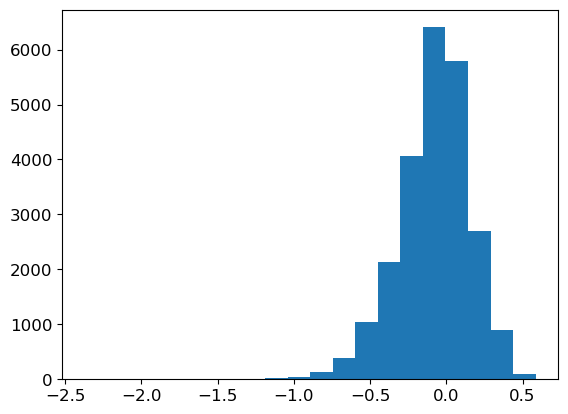

In [35]:
plt.hist(catalog.feh, bins=20)

Both Gaia and the planet-host catalog bring metallicity to the table. But I trust metallicities from CKS more because it's a better instrument and definitionally complete for our planet-host sample.

In [27]:
print(kepler_stellar_enriched.feh_x)
print(kepler_stellar_enriched.feh_y)


0       -0.24
1       -0.06
2       -0.26
3       -0.26
4       -0.24
         ... 
67375   -0.06
67376    0.12
67377   -0.26
67378   -0.28
67379   -0.16
Name: feh_x, Length: 67380, dtype: float64
0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
         ...  
67375    0.012
67376      NaN
67377    0.038
67378   -0.050
67379    0.056
Name: feh_y, Length: 67380, dtype: float64


### Multi:single ratios by age and metallicity

In [37]:
kepler_planet_enriched.groupby('kepid').count().reset_index().groupby('koi_count').count().kepid

koi_count
1    833
2    134
3     38
4     15
5      5
Name: kepid, dtype: int64

Actual binning: evenly sized bins

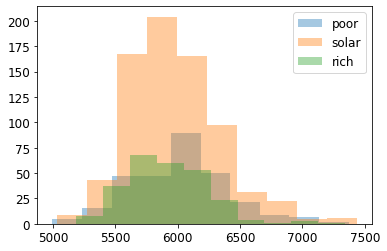

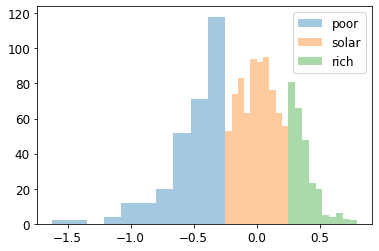

In [36]:
plt.hist(poor.teff, label='poor', alpha=0.4)
plt.hist(solar.teff, label='solar', alpha=0.4)
plt.hist(rich.teff, label='rich', alpha=0.4)
plt.legend()
plt.show()

plt.hist(poor.feh, label='poor', alpha=0.4)
plt.hist(solar.feh, label='solar', alpha=0.4)
plt.hist(rich.feh, label='rich', alpha=0.4)
plt.legend()
plt.show()


In [39]:
age_bin = np.linspace(0.5, 10, 20)

multi_singles_total = []
multi_singles_poor_total = []
multi_singles_solar_total = []
multi_singles_rich_total = []
for i in range(10):
    
    # instantiate new DataFrame for each draw
    kepler_planet_enriched_temp = pd.DataFrame(kepler_planet_enriched.kepid)
    
    # sample Teff, age, and metallicity values, assuming normally distributed errors
    kepler_planet_enriched_temp['age'] = np.random.normal(kepler_planet_enriched.iso_age, kepler_planet_enriched.iso_age_err)
    kepler_planet_enriched_temp['feh'] = np.random.normal(kepler_planet_enriched.feh_x, kepler_planet_enriched.feh_err)
    poor = kepler_planet_enriched_temp.loc[kepler_planet_enriched_temp.feh < -0.25]
    solar = kepler_planet_enriched_temp.loc[(kepler_planet_enriched_temp.feh >= -0.25) & (kepler_planet_enriched_temp.feh <= 0.25)]
    rich = kepler_planet_enriched_temp.loc[kepler_planet_enriched_temp.feh > 0.25]
    
    multi_singles = []
    multi_singles_poor = []
    multi_singles_solar = []
    multi_singles_rich = []
    for j in age_bin[:-1]:
        
        # isolate by age bin
        temp = kepler_planet_enriched_temp.loc[(kepler_planet_enriched_temp.age <= j+0.5) & (kepler_planet_enriched_temp.age > j)]
        # transiting planet distribution
        temp_planets = temp.groupby('kepid').count().reset_index().groupby('age').count()
        # singles
        singles = temp_planets.kepid[1]
        # multis
        multis = temp_planets.kepid.sum() - singles
        # ratio
        ratio = multis/singles      
        multi_singles.append(ratio)
        
        # do this for different metallicity bins
        temp_poor = poor.loc[(poor.age >= j) & (poor.age < j+0.5)]
        temp_solar = solar.loc[(solar.age >= j) & (solar.age < j+0.5)]
        temp_rich = rich.loc[(rich.age >= j) & (rich.age < j+0.5)]
        # transiting planet distribution
        temp_poor_planets = temp_poor.groupby('kepid').count().reset_index().groupby('age').count()
        temp_solar_planets = temp_solar.groupby('kepid').count().reset_index().groupby('age').count()
        temp_rich_planets = temp_rich.groupby('kepid').count().reset_index().groupby('age').count()
        
        # calculate multi:single ratios
        try:
            singles_poor = temp_poor_planets.kepid[1]
            multis_poor = temp_poor_planets.kepid.sum() - singles_poor
            ratio_poor = multis_poor/singles_poor   
        except:
            ratio_poor = np.nan
        
        try:
            singles_solar = temp_solar_planets.kepid[1]
            multis_solar = temp_solar_planets.kepid.sum() - singles_solar
            ratio_solar = multis_solar/singles_solar
        except:
            ratio_solar = np.nan
        
        try:
            singles_rich = temp_rich_planets.kepid[1]
            multis_rich = temp_rich_planets.kepid.sum() - singles_rich
            ratio_rich = multis_rich/singles_rich 
        except:
            ratio_rich = np.nan
            
        multi_singles_poor.append(ratio_poor)
        multi_singles_solar.append(ratio_solar)
        multi_singles_rich.append(ratio_rich)
        
    multi_singles_total.append(multi_singles)
    multi_singles_poor_total.append(multi_singles_poor)
    multi_singles_solar_total.append(multi_singles_solar)
    multi_singles_rich_total.append(multi_singles_rich)

In [40]:
mins = []
maxes = []
poor_mins = []
solar_mins = []
rich_mins = []
poor_maxes = []
solar_maxes = []
rich_maxes = []

for i in range(len(age_bin[:-1])):
    poor_mins.append(np.amin(np.take(multi_singles_poor_total, indices=i, axis=1)))
    poor_maxes.append(np.amax(np.take(multi_singles_poor_total, indices=i, axis=1)))
    
    solar_mins.append(np.amin(np.take(multi_singles_solar_total, indices=i, axis=1)))
    solar_maxes.append(np.amax(np.take(multi_singles_solar_total, indices=i, axis=1)))
    
    rich_mins.append(np.amin(np.take(multi_singles_poor_total, indices=i, axis=1)))
    rich_maxes.append(np.amax(np.take(multi_singles_rich_total, indices=i, axis=1)))
    
    mins.append(np.amin(np.take(multi_singles_total, indices=i, axis=1)))
    maxes.append(np.amax(np.take(multi_singles_total, indices=i, axis=1)))

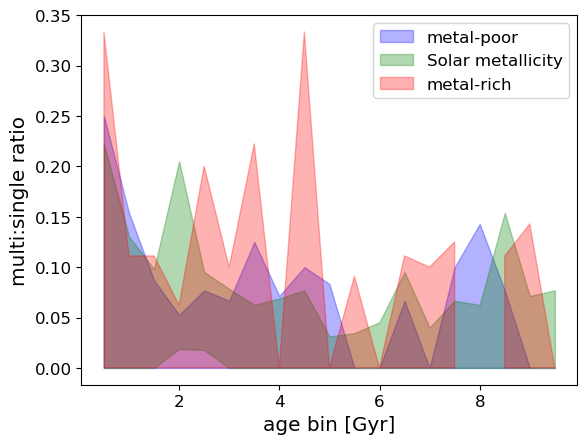

In [41]:
plt.fill_between(age_bin[:-1], poor_mins, poor_maxes, color='blue', alpha=0.3, label='metal-poor')
plt.fill_between(age_bin[:-1], solar_mins, solar_maxes, color='green', alpha=0.3, label='Solar metallicity')
plt.fill_between(age_bin[:-1], rich_mins, rich_maxes, color='red', alpha=0.3, label='metal-rich')

plt.ylabel('multi:single ratio')
plt.xlabel('age bin [Gyr]')
plt.legend()
plt.show()

#### Now, instead of binning, x axis is young-old threshold, with sample divided in two at varying thresholds

In [98]:
age_bin = np.linspace(0.5, 10, 20)

multi_singles_total_young = []
multi_singles_total_old = []
multi_singles_poor_total_young = []
multi_singles_solar_total_young = []
multi_singles_rich_total_young = []
multi_singles_poor_total_old = []
multi_singles_solar_total_old = []
multi_singles_rich_total_old = []

multi_singles_f_total_young = []
multi_singles_g_total_young = []
multi_singles_k_total_young = []
multi_singles_f_total_old = []
multi_singles_g_total_old = []
multi_singles_k_total_old = []

uniques = kepler_planet_enriched.drop_duplicates(subset=['kepid'])
uniques['iso_age_err'] = 0.5 * (uniques.iso_age_err1 + np.abs(uniques.iso_age_err2))
uniques['iso_teff_err'] = 0.5 * (uniques.iso_teff_err1 + np.abs(uniques.iso_teff_err2))

for i in range(100):
    
    multi_singles_young = []
    multi_singles_old = []
    multi_singles_poor_young = []
    multi_singles_poor_old = []
    multi_singles_solar_young = []
    multi_singles_solar_old = []
    multi_singles_rich_young = []
    multi_singles_rich_old = []
    
    multi_singles_f_young = []
    multi_singles_f_old = []
    multi_singles_g_young = []
    multi_singles_g_old = []
    multi_singles_k_young = []
    multi_singles_k_old = []
    
    # sample Teff, age, and metallicity values per star, assuming normally distributed errors
    uniques['age'] = np.random.normal(uniques.iso_age, uniques.iso_age_err)
    uniques['feh'] = np.random.normal(uniques.feh_x, uniques.feh_err)
    uniques['teff'] = np.random.normal(uniques.iso_teff, uniques.iso_teff_err)
    
    kepler_planet_enriched_temp = uniques.merge(kepler_planet_enriched, on='kepid', how='right')
    kepler_planet_enriched_temp.age = kepler_planet_enriched_temp.age.fillna(method='ffill')
    kepler_planet_enriched_temp.feh = kepler_planet_enriched_temp.feh.fillna(method='ffill')
    kepler_planet_enriched_temp.teff_x = kepler_planet_enriched_temp.teff_x.fillna(method='ffill')
    
    f = kepler_planet_enriched_temp.loc[kepler_planet_enriched_temp.teff_x > 6000]
    g = kepler_planet_enriched_temp.loc[(kepler_planet_enriched_temp.teff_x >= 5200) & (kepler_planet_enriched_temp.teff_x <= 6000)]
    k = kepler_planet_enriched_temp.loc[kepler_planet_enriched_temp.teff_x < 5200]
    
    poor = kepler_planet_enriched_temp.loc[kepler_planet_enriched_temp.feh < -0.25]
    solar = kepler_planet_enriched_temp.loc[(kepler_planet_enriched_temp.feh >= -0.25) & (kepler_planet_enriched_temp.feh <= 0.25)]
    rich = kepler_planet_enriched_temp.loc[kepler_planet_enriched_temp.feh > 0.25]
    
    for j in age_bin[:-1]:
        
        # isolate by age bin
        temp_young = kepler_planet_enriched_temp.loc[kepler_planet_enriched_temp.age <= j]
        temp_old = kepler_planet_enriched_temp.loc[kepler_planet_enriched_temp.age > j]
        # transiting planet distribution
        temp_planets_young = temp_young.groupby('kepid').count().reset_index().groupby('age').count()
        temp_planets_old = temp_old.groupby('kepid').count().reset_index().groupby('age').count()
        # singles
        singles_young = temp_planets_young.kepid[0:2].sum()
        singles_old = temp_planets_old.kepid[0:2].sum()
        # multis
        multis_young = temp_planets_young.kepid.sum() - singles_young
        multis_old = temp_planets_old.kepid.sum() - singles_old
        # ratio
        ratio_young = multis_young/singles_young  
        ratio_old = multis_old/singles_old  
        multi_singles_young.append(ratio_young)
        multi_singles_old.append(ratio_old)
        
        # do this for different metallicity bins
        temp_poor_young = poor.loc[poor.age <= j]
        temp_poor_old = poor.loc[poor.age > j]
        temp_solar_young = solar.loc[solar.age <= j]
        temp_solar_old = solar.loc[solar.age > j]
        temp_rich_young = rich.loc[rich.age <= j]
        temp_rich_old = rich.loc[rich.age > j]
        # transiting planet distribution
        temp_poor_planets_young = temp_poor_young.groupby('kepid').count().reset_index().groupby('age').count()
        temp_poor_planets_old = temp_poor_old.groupby('kepid').count().reset_index().groupby('age').count()
        temp_solar_planets_young = temp_solar_young.groupby('kepid').count().reset_index().groupby('age').count()
        temp_solar_planets_old = temp_solar_old.groupby('kepid').count().reset_index().groupby('age').count()
        temp_rich_planets_young = temp_rich_young.groupby('kepid').count().reset_index().groupby('age').count()
        temp_rich_planets_old = temp_rich_old.groupby('kepid').count().reset_index().groupby('age').count()
        
        # calculate multi:single ratios
        try:
            singles_poor_young = temp_poor_planets_young.kepid[0:2].sum()
            multis_poor_young = temp_poor_planets_young.kepid.sum() - singles_poor_young
            ratio_poor_young = multis_poor_young/singles_poor_young   
            
        except:
            ratio_poor_young = np.nan
            
        try:
            singles_poor_old = temp_poor_planets_old.kepid[0:2].sum()
            multis_poor_old = temp_poor_planets_old.kepid.sum() - singles_poor_old
            ratio_poor_old = multis_poor_old/singles_poor_old
        except:
            ratio_poor_old = np.nan
            
        try:
            singles_solar_young = temp_solar_planets_young.kepid[0:2].sum()
            multis_solar_young = temp_solar_planets_young.kepid.sum() - singles_solar_young
            ratio_solar_young = multis_solar_young/singles_solar_young
        except:
            ratio_solar_young = np.nan
            
        try:
            singles_solar_old = temp_solar_planets_old.kepid[0:2].sum()
            multis_solar_old = temp_solar_planets_old.kepid.sum() - singles_solar_old
            ratio_solar_old = multis_solar_old/singles_solar_old
        except:
            ratio_solar_old = np.nan
        
        try:
            singles_rich_young = temp_rich_planets_young.kepid[0:2].sum()
            multis_rich_young = temp_rich_planets_young.kepid.sum() - singles_rich_young
            ratio_rich_young = multis_rich_young/singles_rich_young
        except:
            ratio_rich_young = np.nan
            
        try:
            singles_rich_old = temp_rich_planets_old.kepid[0:2].sum()
            multis_rich_old = temp_rich_planets_old.kepid.sum() - singles_rich_old
            ratio_rich_old = multis_rich_old/singles_rich_old
        except:
            ratio_rich_old = np.nan
            
        multi_singles_poor_young.append(ratio_poor_young)
        multi_singles_poor_old.append(ratio_poor_old)
        multi_singles_solar_young.append(ratio_solar_young)
        multi_singles_solar_old.append(ratio_solar_old)
        multi_singles_rich_young.append(ratio_rich_young)
        multi_singles_rich_old.append(ratio_rich_old)
        
        ### TEFFREY
        # do this for different Teff bins
        temp_f_young = f.loc[f.age <= j]
        temp_f_old = f.loc[f.age > j]
        temp_g_young = g.loc[g.age <= j]
        temp_g_old = g.loc[g.age > j]
        temp_k_young = k.loc[k.age <= j]
        temp_k_old = k.loc[k.age > j]
        # transiting planet distribution
        temp_f_planets_young = temp_f_young.groupby('kepid').count().reset_index().groupby('age').count()
        temp_f_planets_old = temp_f_old.groupby('kepid').count().reset_index().groupby('age').count()
        temp_g_planets_young = temp_g_young.groupby('kepid').count().reset_index().groupby('age').count()
        temp_g_planets_old = temp_g_old.groupby('kepid').count().reset_index().groupby('age').count()
        temp_k_planets_young = temp_k_young.groupby('kepid').count().reset_index().groupby('age').count()
        temp_k_planets_old = temp_k_old.groupby('kepid').count().reset_index().groupby('age').count()
        
        # calculate multi:single ratios
        try:
            singles_f_young = temp_f_planets_young.kepid[0:2].sum()
            multis_f_young = temp_f_planets_young.kepid.sum() - singles_f_young
            ratio_f_young = multis_f_young/singles_f_young   
            
        except:
            ratio_f_young = np.nan
            
        try:
            singles_f_old = temp_f_planets_old.kepid[0:2].sum()
            multis_f_old = temp_f_planets_old.kepid.sum() - singles_f_old
            ratio_f_old = multis_f_old/singles_f_old
        except:
            ratio_f_old = np.nan
            
        try:
            singles_g_young = temp_g_planets_young.kepid[0:2].sum()
            multis_g_young = temp_g_planets_young.kepid.sum() - singles_g_young
            ratio_g_young = multis_g_young/singles_g_young
        except:
            ratio_g_young = np.nan
            
        try:
            singles_g_old = temp_g_planets_old.kepid[0:2].sum()
            multis_g_old = temp_g_planets_old.kepid.sum() - singles_g_old
            ratio_g_old = multis_g_old/singles_g_old
        except:
            ratio_g_old = np.nan
        
        try:
            singles_k_young = temp_k_planets_young.kepid[0:2].sum()
            multis_k_young = temp_k_planets_young.kepid.sum() - singles_k_young
            ratio_k_young = multis_k_young/singles_k_young
        except:
            ratio_k_young = np.nan
            
        try:
            singles_k_old = temp_k_planets_old.kepid[0:2].sum()
            multis_k_old = temp_k_planets_old.kepid.sum() - singles_k_old
            ratio_k_old = multis_k_old/singles_k_old
        except:
            ratio_k_old = np.nan
            
        multi_singles_f_young.append(ratio_f_young)
        multi_singles_f_old.append(ratio_f_old)
        multi_singles_g_young.append(ratio_g_young)
        multi_singles_g_old.append(ratio_g_old)
        multi_singles_k_young.append(ratio_k_young)
        multi_singles_k_old.append(ratio_k_old)
        
        
    multi_singles_total_young.append(multi_singles_young)
    multi_singles_total_old.append(multi_singles_old)
    multi_singles_poor_total_young.append(multi_singles_poor_young)
    multi_singles_poor_total_old.append(multi_singles_poor_old)
    multi_singles_solar_total_young.append(multi_singles_solar_young)
    multi_singles_solar_total_old.append(multi_singles_solar_old)
    multi_singles_rich_total_young.append(multi_singles_rich_young)
    multi_singles_rich_total_old.append(multi_singles_rich_old)
    
    #multi_singles_total_young.append(multi_singles_young)
    #multi_singles_total_old.append(multi_singles_old)
    multi_singles_f_total_young.append(multi_singles_f_young)
    multi_singles_f_total_old.append(multi_singles_f_old)
    multi_singles_g_total_young.append(multi_singles_g_young)
    multi_singles_g_total_old.append(multi_singles_g_old)
    multi_singles_k_total_young.append(multi_singles_k_young)
    multi_singles_k_total_old.append(multi_singles_k_old)
    

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a 

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packag

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packag

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packag

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCop

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCop

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCop

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packag

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCop

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packag

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packag

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

2 sigma envelopes of multi to single ratios, disaggregated by metallicity bin

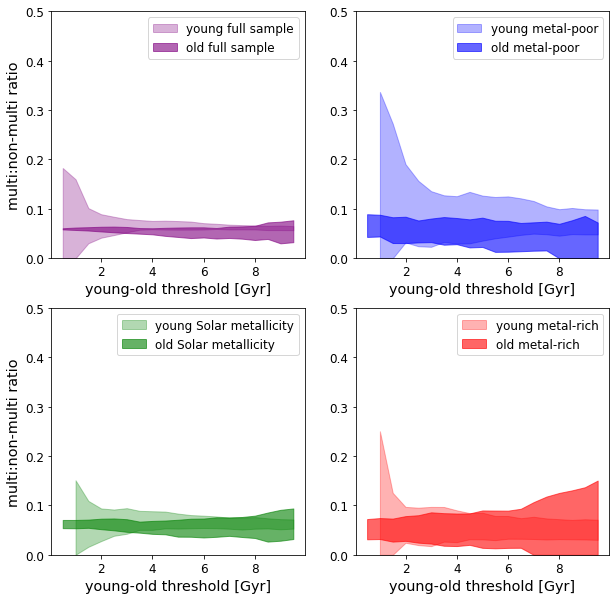

In [101]:
fig, ((ax4, ax1), (ax2, ax3)) = plt.subplots(2,2, figsize=(10, 10))#, sharex=True)

ax1.fill_between(age_bin[:-1], np.quantile(multi_singles_poor_total_young, 0.05, axis=0), 
                 np.quantile(multi_singles_poor_total_young, 0.95, axis=0), color='blue', alpha=0.3, label='young metal-poor')
ax1.fill_between(age_bin[:-1], np.quantile(multi_singles_poor_total_old, 0.05, axis=0), 
                 np.quantile(multi_singles_poor_total_old, 0.95, axis=0), color='blue', alpha=0.6, label='old metal-poor')
ax1.legend()
ax1.set_ylim([0, 0.5])
ax1.set_xlabel('young-old threshold [Gyr]')

ax2.fill_between(age_bin[:-1], np.quantile(multi_singles_solar_total_young, 0.05, axis=0), 
                 np.quantile(multi_singles_solar_total_young, 0.95, axis=0), color='green', alpha=0.3, label='young Solar metallicity')
ax2.fill_between(age_bin[:-1], np.quantile(multi_singles_solar_total_old, 0.05, axis=0), 
                 np.quantile(multi_singles_solar_total_old, 0.95, axis=0), color='green', alpha=0.6, label='old Solar metallicity')
ax2.legend()
ax2.set_ylim([0, 0.5])
ax2.set_xlabel('young-old threshold [Gyr]')
ax2.set_ylabel('multi:non-multi ratio')

ax3.fill_between(age_bin[:-1], np.quantile(multi_singles_rich_total_young, 0.05, axis=0), 
                 np.quantile(multi_singles_rich_total_young, 0.95, axis=0), color='red', alpha=0.3, label='young metal-rich')
ax3.fill_between(age_bin[:-1], np.quantile(multi_singles_rich_total_old, 0.05, axis=0), 
                 np.quantile(multi_singles_rich_total_old, 0.95, axis=0), color='red', alpha=0.6, label='old metal-rich')
ax3.legend()
ax3.set_xlabel('young-old threshold [Gyr]')
ax3.set_ylim([0, 0.5])

ax4.fill_between(age_bin[:-1], np.quantile(multi_singles_total_young, 0.05, axis=0), 
                 np.quantile(multi_singles_total_young, 0.95, axis=0), color='purple', alpha=0.3, label='young full sample')
ax4.fill_between(age_bin[:-1], np.quantile(multi_singles_total_old, 0.05, axis=0), 
                 np.quantile(multi_singles_total_old, 0.95, axis=0), color='purple', alpha=0.6, label='old full sample')
ax4.legend()
ax4.set_ylim([0, 0.5])
ax4.set_ylabel('multi:non-multi ratio')
ax4.set_xlabel('young-old threshold [Gyr]')


plt.legend()
path = '/Users/chris/Desktop/mastrangelo/'
plt.savefig(path+'figures/multi-single-metallicity-2sigma.png', facecolor='white', bbox_inches='tight')
plt.show()

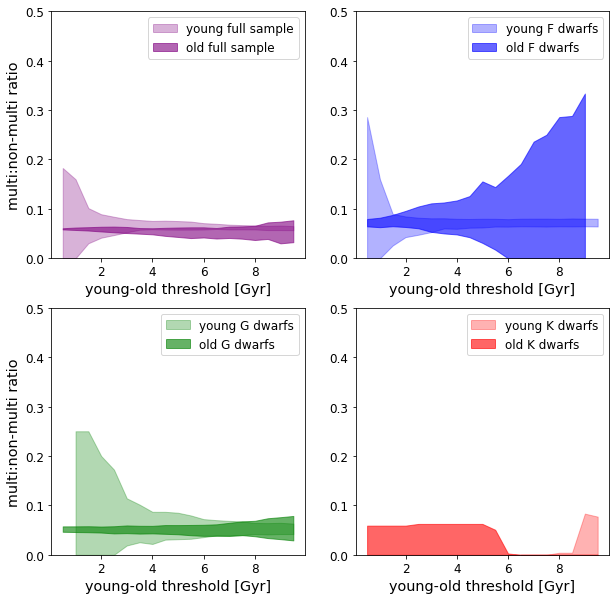

In [102]:
fig, ((ax4, ax1), (ax2, ax3)) = plt.subplots(2,2, figsize=(10, 10))

low = 0.32
high = 0.68
low2 = 0.05
high2 = 0.95

ax1.fill_between(age_bin[:-1], np.quantile(multi_singles_f_total_young, low2, axis=0), 
                 np.quantile(multi_singles_f_total_young, high2, axis=0), color='blue', alpha=0.3, label='young F dwarfs')
ax1.fill_between(age_bin[:-1], np.quantile(multi_singles_f_total_old, low2, axis=0), 
                 np.quantile(multi_singles_f_total_old, high2, axis=0), color='blue', alpha=0.6, label='old F dwarfs')
#ax1.fill_between(age_bin[:-1], np.quantile(multi_singles_poor_total_young, low2, axis=0),
#                 np.quantile(multi_singles_poor_total_young, high2, axis=0), color='blue', alpha=0.3, label='young metal-poor')
#ax1.fill_between(age_bin[:-1], np.quantile(multi_singles_poor_total_old, low2, axis=0),
#                 np.quantile(multi_singles_poor_total_old, high2, axis=0), color='blue', alpha=0.6, label='old metal-poor')
ax1.legend()
ax1.set_ylim([0, 0.5])
ax1.set_xlabel('young-old threshold [Gyr]')


ax2.fill_between(age_bin[:-1], np.quantile(multi_singles_g_total_young, low2, axis=0), 
                 np.quantile(multi_singles_g_total_young, high2, axis=0), color='green', alpha=0.3, label='young G dwarfs')
ax2.fill_between(age_bin[:-1], np.quantile(multi_singles_g_total_old, low2, axis=0), 
                 np.quantile(multi_singles_g_total_old, high2, axis=0), color='green', alpha=0.6, label='old G dwarfs')
ax2.legend()
ax2.set_ylim([0, 0.5])
ax2.set_xlabel('young-old threshold [Gyr]')
ax2.set_ylabel('multi:non-multi ratio')

#"""
ax3.fill_between(age_bin[:-1], np.quantile(multi_singles_k_total_young, low2, axis=0), 
                 np.quantile(multi_singles_k_total_young, high2, axis=0), color='red', alpha=0.3, label='young K dwarfs')
ax3.fill_between(age_bin[:-1], np.quantile(multi_singles_k_total_old, low2, axis=0), 
                 np.quantile(multi_singles_k_total_old, high2, axis=0), color='red', alpha=0.6, label='old K dwarfs')
ax3.legend()
ax3.set_xlabel('young-old threshold [Gyr]')
ax3.set_ylim([0, 0.5])
#"""
ax4.fill_between(age_bin[:-1], np.quantile(multi_singles_total_young, low2, axis=0), 
                 np.quantile(multi_singles_total_young, high2, axis=0), color='purple', alpha=0.3, label='young full sample')
ax4.fill_between(age_bin[:-1], np.quantile(multi_singles_total_old, low2, axis=0), 
                 np.quantile(multi_singles_total_old, high2, axis=0), color='purple', alpha=0.6, label='old full sample')
ax4.legend()
ax4.set_ylim([0, 0.5])
ax4.set_ylabel('multi:non-multi ratio')
ax4.set_xlabel('young-old threshold [Gyr]')

#fig.delaxes(ax3) # The indexing is zero-based here

plt.legend()
path = '/Users/chris/Desktop/mastrangelo/'
plt.savefig(path+'figures/multi-single-teff-2sigma.png', facecolor='white', bbox_inches='tight')
plt.show()

65


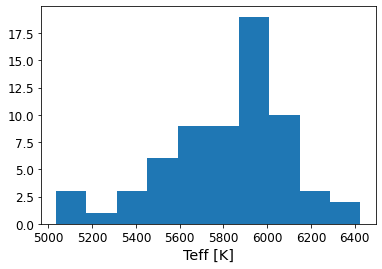

In [63]:
print(len(poor.loc[poor.age > 8.5]))

plt.hist(poor.loc[poor.age > 8.5].teff_x)
plt.xlabel('Teff [K]')
plt.show()

Why do metal-poor stars have fewer multis than Solar- and high-metallicity stars? I first considered whether the definition of metal-poor/rich mattered (re-ran the above using -0.5 and 0.5 thresholds, which leads to small number stats for metal-rich stars, but at least the apparent lack of multis in metal-poor stars is gone). Then, I considered whether the definition of singles and mutlis mattered. After all, compact multis are, even in our paper's definition, not intrinsic two-planet systems. Of course, the Kepler yield is what we see, not what is. But, when I redefine compact multis to 3+ planets, I do finally get metal-poor stars having higher multi:single ratio than Solar- and high-metallicity stars (see below).

In [28]:
poor = kepler_planet_enriched_temp.loc[kepler_planet_enriched_temp.feh < -0.25]
solar = kepler_planet_enriched_temp.loc[(kepler_planet_enriched_temp.feh >= -0.25) & (kepler_planet_enriched_temp.feh <= 0.25)]
rich = kepler_planet_enriched_temp.loc[kepler_planet_enriched_temp.feh > 0.25]
    
poor_singles = poor.groupby('kepid').count().reset_index().groupby('age').count().kepid[1].sum() # 0:2
poor_multis = poor.groupby('kepid').count().reset_index().groupby('age').count().kepid.sum() - poor_singles
poor_ratio = poor_multis/poor_singles

solar_singles = solar.groupby('kepid').count().reset_index().groupby('age').count().kepid[1].sum()
solar_multis = solar.groupby('kepid').count().reset_index().groupby('age').count().kepid.sum() - solar_singles
solar_ratio = solar_multis/solar_singles

rich_singles = rich.groupby('kepid').count().reset_index().groupby('age').count().kepid[1].sum()
rich_multis = rich.groupby('kepid').count().reset_index().groupby('age').count().kepid.sum() - rich_singles
rich_ratio = rich_multis/rich_singles

print(poor_ratio, solar_ratio, rich_ratio)

0.1897810218978102 0.24087591240875914 0.23129251700680273


In [29]:
all_singles = kepler_planet_enriched_temp.groupby('kepid').count().reset_index().groupby('age').count().kepid[0:2].sum()
all_multis = kepler_planet_enriched_temp.groupby('kepid').count().reset_index().groupby('age').count().kepid.sum() - all_singles
all_ratio = all_multis/all_singles
print(all_ratio)

0.05997931747673216


How about with 1 sigma?

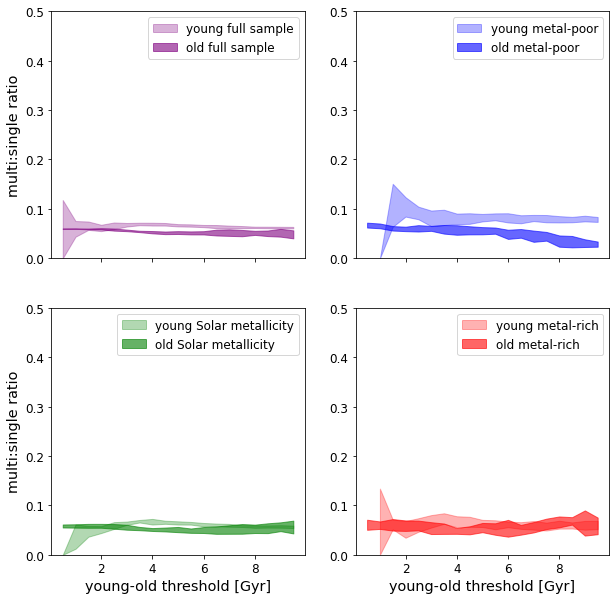

In [31]:
fig, ((ax4, ax1), (ax2, ax3)) = plt.subplots(2,2, figsize=(10, 10), sharex=True)

low = 0.32
high = 0.68
low2 = 0.05
high2 = 0.95

ax1.fill_between(age_bin[:-1], np.quantile(multi_singles_poor_total_young, low, axis=0), 
                 np.quantile(multi_singles_poor_total_young, high, axis=0), color='blue', alpha=0.3, label='young metal-poor')
ax1.fill_between(age_bin[:-1], np.quantile(multi_singles_poor_total_old, low, axis=0), 
                 np.quantile(multi_singles_poor_total_old, high, axis=0), color='blue', alpha=0.6, label='old metal-poor')
#ax1.fill_between(age_bin[:-1], np.quantile(multi_singles_poor_total_young, low2, axis=0),
#                 np.quantile(multi_singles_poor_total_young, high2, axis=0), color='blue', alpha=0.3, label='young metal-poor')
#ax1.fill_between(age_bin[:-1], np.quantile(multi_singles_poor_total_old, low2, axis=0),
#                 np.quantile(multi_singles_poor_total_old, high2, axis=0), color='blue', alpha=0.6, label='old metal-poor')
ax1.legend()
ax1.set_ylim([0, 0.5])

ax2.fill_between(age_bin[:-1], np.quantile(multi_singles_solar_total_young, low, axis=0), 
                 np.quantile(multi_singles_solar_total_young, high, axis=0), color='green', alpha=0.3, label='young Solar metallicity')
ax2.fill_between(age_bin[:-1], np.quantile(multi_singles_solar_total_old, low, axis=0), 
                 np.quantile(multi_singles_solar_total_old, high, axis=0), color='green', alpha=0.6, label='old Solar metallicity')
ax2.legend()
ax2.set_ylim([0, 0.5])
ax2.set_xlabel('young-old threshold [Gyr]')
ax2.set_ylabel('multi:single ratio')

ax3.fill_between(age_bin[:-1], np.quantile(multi_singles_rich_total_young, low, axis=0), 
                 np.quantile(multi_singles_rich_total_young, high, axis=0), color='red', alpha=0.3, label='young metal-rich')
ax3.fill_between(age_bin[:-1], np.quantile(multi_singles_rich_total_old, low, axis=0), 
                 np.quantile(multi_singles_rich_total_old, high, axis=0), color='red', alpha=0.6, label='old metal-rich')
ax3.legend()
ax3.set_xlabel('young-old threshold [Gyr]')
ax3.set_ylim([0, 0.5])

ax4.fill_between(age_bin[:-1], np.quantile(multi_singles_total_young, low, axis=0), 
                 np.quantile(multi_singles_total_young, high, axis=0), color='purple', alpha=0.3, label='young full sample')
ax4.fill_between(age_bin[:-1], np.quantile(multi_singles_total_old, low, axis=0), 
                 np.quantile(multi_singles_total_old, high, axis=0), color='purple', alpha=0.6, label='old full sample')
ax4.legend()
ax4.set_ylim([0, 0.5])
ax4.set_ylabel('multi:single ratio')


plt.legend()
path = '/Users/chris/Desktop/mastrangelo/'
plt.savefig(path+'figures/multi-single-metallicity-1sigma.png', facecolor='white', bbox_inches='tight')
plt.show()

And what if we did this by Teff instead of metallicity?

In [74]:
age_bin = np.linspace(0.5, 10, 20)

multi_singles_total_young = []
multi_singles_total_old = []
multi_singles_f_total_young = []
multi_singles_g_total_young = []
multi_singles_k_total_young = []
multi_singles_f_total_old = []
multi_singles_g_total_old = []
multi_singles_k_total_old = []

uniques = kepler_planet_enriched.drop_duplicates(subset=['kepid'])
uniques['iso_age_err'] = 0.5 * (uniques.iso_age_err1 + np.abs(uniques.iso_age_err2))
uniques['iso_teff_err'] = 0.5 * (uniques.iso_teff_err1 + np.abs(uniques.iso_teff_err2))
#kepler_planet_enriched['iso_age_err'] = 0.5 * (kepler_planet_enriched.iso_age_err1 + np.abs(kepler_planet_enriched.iso_age_err2))
#kepler_planet_enriched['iso_teff_err'] = 0.5 * (kepler_planet_enriched.iso_teff_err1 + np.abs(kepler_planet_enriched.iso_teff_err2))

for i in range(10):
    
    multi_singles_young = []
    multi_singles_old = []
    multi_singles_f_young = []
    multi_singles_f_old = []
    multi_singles_g_young = []
    multi_singles_g_old = []
    multi_singles_k_young = []
    multi_singles_k_old = []
    
    # sample Teff, age, and metallicity values per star, assuming normally distributed errors
    uniques['age'] = np.random.normal(uniques.iso_age, uniques.iso_age_err)
    uniques['teff'] = np.random.normal(uniques.iso_teff, uniques.iso_teff_err)
    #kepler_planet_enriched['age'] = np.random.normal(kepler_planet_enriched.iso_age, kepler_planet_enriched.iso_age_err)
    #kepler_planet_enriched['teff'] = np.random.normal(kepler_planet_enriched.iso_teff, kepler_planet_enriched.iso_teff_err)
    
    kepler_planet_enriched_temp = uniques.merge(kepler_planet_enriched, on='kepid', how='right')
    kepler_planet_enriched_temp.age = kepler_planet_enriched_temp.age.fillna(method='ffill')
    kepler_planet_enriched_temp.teff_x = kepler_planet_enriched_temp.teff_x.fillna(method='ffill')
    
    f = kepler_planet_enriched_temp.loc[kepler_planet_enriched_temp.teff_x > 6000]
    g = kepler_planet_enriched_temp.loc[(kepler_planet_enriched_temp.teff_x >= 5200) & (kepler_planet_enriched_temp.teff_x <= 6000)]
    k = kepler_planet_enriched_temp.loc[kepler_planet_enriched_temp.teff_x < 5200]
    
    for j in age_bin[:-1]:
        
        # isolate by age bin
        temp_young = kepler_planet_enriched_temp.loc[kepler_planet_enriched_temp.age <= j]
        temp_old = kepler_planet_enriched_temp.loc[kepler_planet_enriched_temp.age > j]
        # transiting planet distribution
        temp_planets_young = temp_young.groupby('kepid').count().reset_index().groupby('age').count()
        temp_planets_old = temp_old.groupby('kepid').count().reset_index().groupby('age').count()

        try:
            singles_young = temp_planets_young.kepid[1]
            multis_young = temp_planets_young.kepid.sum() - singles_young
            ratio_young = multis_young/singles_young  
        except:
            ratio_young = np.nan
            
        try:
            singles_old = temp_planets_old.kepid[1]
            multis_old = temp_planets_old.kepid.sum() - singles_old
            ratio_old = multis_old/singles_old  
        except:
            ratio_old = np.nan
        
        multi_singles_young.append(ratio_young)
        multi_singles_old.append(ratio_old)
        
        # do this for different Teff bins
        temp_f_young = f.loc[f.age <= j]
        temp_f_old = f.loc[f.age > j]
        temp_g_young = g.loc[g.age <= j]
        temp_g_old = g.loc[g.age > j]
        temp_k_young = k.loc[k.age <= j]
        temp_k_old = k.loc[k.age > j]
        # transiting planet distribution
        temp_f_planets_young = temp_f_young.groupby('kepid').count().reset_index().groupby('age').count()
        temp_f_planets_old = temp_f_old.groupby('kepid').count().reset_index().groupby('age').count()
        temp_g_planets_young = temp_g_young.groupby('kepid').count().reset_index().groupby('age').count()
        temp_g_planets_old = temp_g_old.groupby('kepid').count().reset_index().groupby('age').count()
        temp_k_planets_young = temp_k_young.groupby('kepid').count().reset_index().groupby('age').count()
        temp_k_planets_old = temp_k_old.groupby('kepid').count().reset_index().groupby('age').count()
        
        # calculate multi:single ratios
        try:
            singles_f_young = temp_f_planets_young.kepid[0:2].sum()
            multis_f_young = temp_f_planets_young.kepid.sum() - singles_f_young
            ratio_f_young = multis_f_young/singles_f_young   
            
        except:
            ratio_f_young = np.nan
            
        try:
            singles_f_old = temp_f_planets_old.kepid[0:2].sum()
            multis_f_old = temp_f_planets_old.kepid.sum() - singles_f_old
            ratio_f_old = multis_f_old/singles_f_old
        except:
            ratio_f_old = np.nan
            
        try:
            singles_g_young = temp_g_planets_young.kepid[0:2].sum()
            multis_g_young = temp_g_planets_young.kepid.sum() - singles_g_young
            ratio_g_young = multis_g_young/singles_g_young
        except:
            ratio_g_young = np.nan
            
        try:
            singles_g_old = temp_g_planets_old.kepid[0:2].sum()
            multis_g_old = temp_g_planets_old.kepid.sum() - singles_g_old
            ratio_g_old = multis_g_old/singles_g_old
        except:
            ratio_g_old = np.nan
        
        try:
            singles_k_young = temp_k_planets_young.kepid[0:2].sum()
            multis_k_young = temp_k_planets_young.kepid.sum() - singles_k_young
            ratio_k_young = multis_k_young/singles_k_young
        except:
            ratio_k_young = np.nan
            
        try:
            singles_k_old = temp_k_planets_old.kepid[0:2].sum()
            multis_k_old = temp_k_planets_old.kepid.sum() - singles_k_old
            ratio_k_old = multis_k_old/singles_k_old
        except:
            ratio_k_old = np.nan
            
        multi_singles_f_young.append(ratio_f_young)
        multi_singles_f_old.append(ratio_f_old)
        multi_singles_g_young.append(ratio_g_young)
        multi_singles_g_old.append(ratio_g_old)
        multi_singles_k_young.append(ratio_k_young)
        multi_singles_k_old.append(ratio_k_old)
        
    multi_singles_total_young.append(multi_singles_young)
    multi_singles_total_old.append(multi_singles_old)
    multi_singles_f_total_young.append(multi_singles_f_young)
    multi_singles_f_total_old.append(multi_singles_f_old)
    multi_singles_g_total_young.append(multi_singles_g_young)
    multi_singles_g_total_old.append(multi_singles_g_old)
    multi_singles_k_total_young.append(multi_singles_k_young)
    multi_singles_k_total_old.append(multi_singles_k_old)
    

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packag

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in long_scalars
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in long_scalars


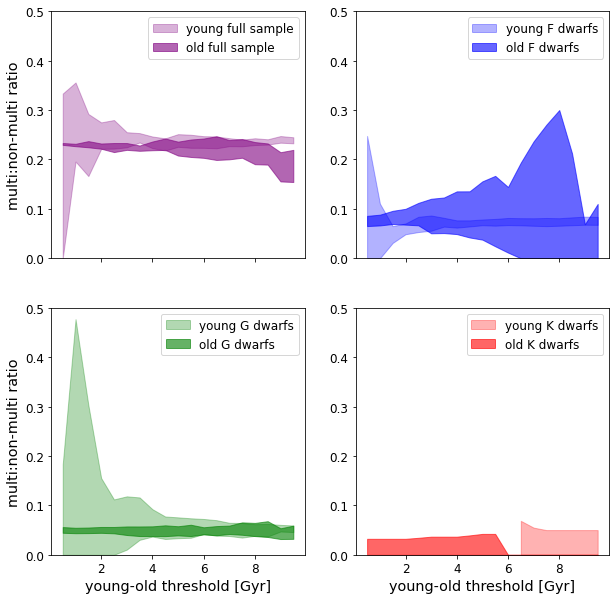

In [75]:
fig, ((ax4, ax1), (ax2, ax3)) = plt.subplots(2,2, figsize=(10, 10), sharex=True)

low = 0.32
high = 0.68
low2 = 0.05
high2 = 0.95

ax1.fill_between(age_bin[:-1], np.quantile(multi_singles_f_total_young, low2, axis=0), 
                 np.quantile(multi_singles_f_total_young, high2, axis=0), color='blue', alpha=0.3, label='young F dwarfs')
ax1.fill_between(age_bin[:-1], np.quantile(multi_singles_f_total_old, low2, axis=0), 
                 np.quantile(multi_singles_f_total_old, high2, axis=0), color='blue', alpha=0.6, label='old F dwarfs')
#ax1.fill_between(age_bin[:-1], np.quantile(multi_singles_poor_total_young, low2, axis=0),
#                 np.quantile(multi_singles_poor_total_young, high2, axis=0), color='blue', alpha=0.3, label='young metal-poor')
#ax1.fill_between(age_bin[:-1], np.quantile(multi_singles_poor_total_old, low2, axis=0),
#                 np.quantile(multi_singles_poor_total_old, high2, axis=0), color='blue', alpha=0.6, label='old metal-poor')
ax1.legend()
ax1.set_ylim([0, 0.5])

ax2.fill_between(age_bin[:-1], np.quantile(multi_singles_g_total_young, low2, axis=0), 
                 np.quantile(multi_singles_g_total_young, high2, axis=0), color='green', alpha=0.3, label='young G dwarfs')
ax2.fill_between(age_bin[:-1], np.quantile(multi_singles_g_total_old, low2, axis=0), 
                 np.quantile(multi_singles_g_total_old, high2, axis=0), color='green', alpha=0.6, label='old G dwarfs')
ax2.legend()
ax2.set_ylim([0, 0.5])
ax2.set_xlabel('young-old threshold [Gyr]')
ax2.set_ylabel('multi:non-multi ratio')

ax3.fill_between(age_bin[:-1], np.quantile(multi_singles_k_total_young, low2, axis=0), 
                 np.quantile(multi_singles_k_total_young, high2, axis=0), color='red', alpha=0.3, label='young K dwarfs')
ax3.fill_between(age_bin[:-1], np.quantile(multi_singles_k_total_old, low2, axis=0), 
                 np.quantile(multi_singles_k_total_old, high2, axis=0), color='red', alpha=0.6, label='old K dwarfs')
ax3.legend()
ax3.set_xlabel('young-old threshold [Gyr]')
ax3.set_ylim([0, 0.5])

ax4.fill_between(age_bin[:-1], np.quantile(multi_singles_total_young, low2, axis=0), 
                 np.quantile(multi_singles_total_young, high2, axis=0), color='purple', alpha=0.3, label='young full sample')
ax4.fill_between(age_bin[:-1], np.quantile(multi_singles_total_old, low2, axis=0), 
                 np.quantile(multi_singles_total_old, high2, axis=0), color='purple', alpha=0.6, label='old full sample')
ax4.legend()
ax4.set_ylim([0, 0.5])
ax4.set_ylabel('multi:non-multi ratio')


plt.legend()
path = '/Users/chris/Desktop/mastrangelo/'
plt.savefig(path+'figures/multi-single-teff-2sigma.png', facecolor='white', bbox_inches='tight')
plt.show()

The next two cells are the old (and slow) way I generated these plots, which are less flexible than using np.quantile.

In [39]:
mins_young = []
maxes_young = []
poor_mins_young = []
solar_mins_young = []
rich_mins_young = []
poor_maxes_young = []
solar_maxes_young = []
rich_maxes_young = []

mins_old = []
maxes_old = []
poor_mins_old = []
solar_mins_old = []
rich_mins_old = []
poor_maxes_old = []
solar_maxes_old = []
rich_maxes_old = []

for i in range(len(age_bin[:-1])):
    # young
    poor_mins_young.append(np.amin(np.take(multi_singles_poor_total_young, indices=i, axis=1)))
    poor_maxes_young.append(np.amax(np.take(multi_singles_poor_total_young, indices=i, axis=1)))
    
    solar_mins_young.append(np.amin(np.take(multi_singles_solar_total_young, indices=i, axis=1)))
    solar_maxes_young.append(np.amax(np.take(multi_singles_solar_total_young, indices=i, axis=1)))
    
    rich_mins_young.append(np.amin(np.take(multi_singles_poor_total_young, indices=i, axis=1)))
    rich_maxes_young.append(np.amax(np.take(multi_singles_rich_total_young, indices=i, axis=1)))
    
    mins_young.append(np.amin(np.take(multi_singles_total_young, indices=i, axis=1)))
    maxes_young.append(np.amax(np.take(multi_singles_total_young, indices=i, axis=1)))
    
    # old
    poor_mins_old.append(np.amin(np.take(multi_singles_poor_total_old, indices=i, axis=1)))
    poor_maxes_old.append(np.amax(np.take(multi_singles_poor_total_old, indices=i, axis=1)))
    
    solar_mins_old.append(np.amin(np.take(multi_singles_solar_total_old, indices=i, axis=1)))
    solar_maxes_old.append(np.amax(np.take(multi_singles_solar_total_old, indices=i, axis=1)))
    
    rich_mins_old.append(np.amin(np.take(multi_singles_poor_total_old, indices=i, axis=1)))
    rich_maxes_old.append(np.amax(np.take(multi_singles_rich_total_old, indices=i, axis=1)))
    
    mins_old.append(np.amin(np.take(multi_singles_total_old, indices=i, axis=1)))
    maxes_old.append(np.amax(np.take(multi_singles_total_old, indices=i, axis=1)))
    

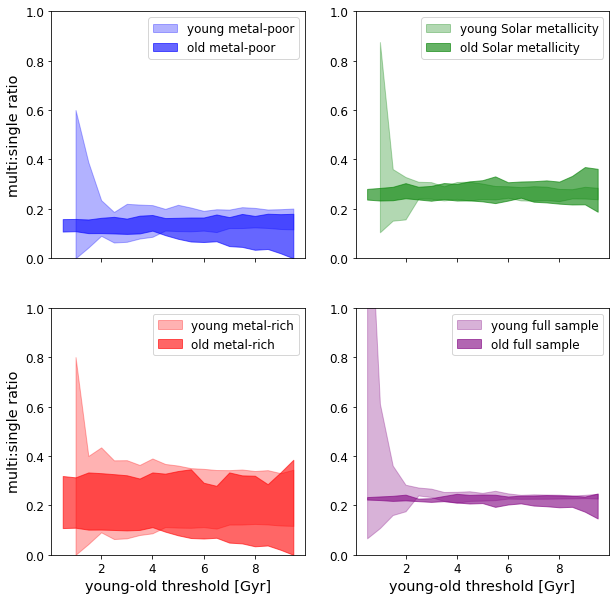

In [41]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10, 10), sharex=True)

ax1.fill_between(age_bin[:-1], poor_mins_young, poor_maxes_young, color='blue', alpha=0.3, label='young metal-poor')
ax1.fill_between(age_bin[:-1], poor_mins_old, poor_maxes_old, color='blue', alpha=0.6, label='old metal-poor')
ax1.set_ylabel('multi:single ratio')
ax1.legend()
ax1.set_ylim([0, 1])

ax2.fill_between(age_bin[:-1], solar_mins_young, solar_maxes_young, color='green', alpha=0.3, label='young Solar metallicity')
ax2.fill_between(age_bin[:-1], solar_mins_old, solar_maxes_old, color='green', alpha=0.6, label='old Solar metallicity')
ax2.legend()
ax2.set_ylim([0, 1])

ax3.fill_between(age_bin[:-1], rich_mins_young, rich_maxes_young, color='red', alpha=0.3, label='young metal-rich')
ax3.fill_between(age_bin[:-1], rich_mins_old, rich_maxes_old, color='red', alpha=0.6, label='old metal-rich')
ax3.legend()
ax3.set_ylabel('multi:single ratio')
ax3.set_xlabel('young-old threshold [Gyr]')
ax3.set_ylim([0, 1])

ax4.fill_between(age_bin[:-1], mins_young, maxes_young, color='purple', alpha=0.3, label='young full sample')
ax4.fill_between(age_bin[:-1], mins_old, maxes_old, color='purple', alpha=0.6, label='old full sample')
ax4.legend()
ax4.set_xlabel('young-old threshold [Gyr]')
ax4.set_ylim([0, 1])

plt.legend()
#plt.savefig(path+'figures/multi-single-metallicity.png', facecolor='white', bbox_inches='tight')
plt.show()

In [36]:
len(poor), len(solar), len(rich), len(kepler_planet_enriched)

(110, 1157, 33, 1300)

#### Let's do this across F- and G-dwarfs only

In [26]:
fs = kepler_planet_enriched.loc[(kepler_planet_enriched.iso_teff < 7500) & (kepler_planet_enriched.iso_teff > 6000)]
print("F dwarfs with planets: ", len(fs.kepid.unique()))

print("metal-poor F dwarfs with planets: ", len(fs.loc[fs.feh_x < -0.25].kepid.unique()))
print("Solar metallicity F dwarfs with planets: ", len(fs.loc[(fs.feh_x > -0.25) & (fs.feh_x < 0.25)].kepid.unique()))

gs = kepler_planet_enriched.loc[(kepler_planet_enriched.iso_teff < 6000) & (kepler_planet_enriched.iso_teff > 5300)]
print("G dwarfs with planets: ", len(gs.kepid.unique()))

F dwarfs with planets:  429
metal-poor F dwarfs with planets:  87
Solar metallicity F dwarfs with planets:  301
G dwarfs with planets:  561


Does it matter whether I use iso_teff or teff?

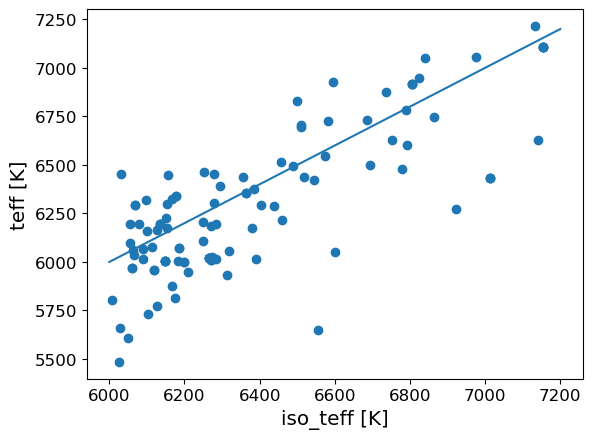

In [47]:
plt.scatter(fs.loc[fs.feh_x < -0.25].iso_teff, fs.loc[(fs.feh_x < -0.25)].teff)
plt.plot(np.linspace(6000, 7200, 100), np.linspace(6000, 7200, 100))
plt.xlabel('iso_teff [K]')
plt.ylabel('teff [K]')
plt.show()

#### Now just for F dwarfs

In [52]:
age_bin = np.linspace(0.5, 10, 20)

multi_singles_total_young = []
multi_singles_total_old = []
multi_singles_poor_total_young = []
multi_singles_solar_total_young = []
multi_singles_rich_total_young = []
multi_singles_poor_total_old = []
multi_singles_solar_total_old = []
multi_singles_rich_total_old = []

uniques = kepler_planet_enriched.drop_duplicates(subset=['kepid'])
uniques['iso_age_err'] = 0.5 * (uniques.iso_age_err1 + np.abs(uniques.iso_age_err2))
uniques['iso_teff_err'] = 0.5 * (uniques.iso_teff_err1 + np.abs(uniques.iso_teff_err2))

for i in range(10):
    
    multi_singles_young = []
    multi_singles_old = []
    multi_singles_poor_young = []
    multi_singles_poor_old = []
    multi_singles_solar_young = []
    multi_singles_solar_old = []
    multi_singles_rich_young = []
    multi_singles_rich_old = []
    
    # sample Teff, age, and metallicity values per star, assuming normally distributed errors
    uniques['age'] = np.random.normal(uniques.iso_age, uniques.iso_age_err)
    uniques['feh'] = np.random.normal(uniques.feh_x, uniques.feh_err)
    uniques['teffs'] = np.random.normal(uniques.iso_teff, uniques.iso_teff_err)

    kepler_planet_enriched_temp = uniques.merge(kepler_planet_enriched, on='kepid', how='right')
    kepler_planet_enriched_temp.age = kepler_planet_enriched_temp.age.fillna(method='ffill')
    kepler_planet_enriched_temp.feh = kepler_planet_enriched_temp.feh.fillna(method='ffill')
    kepler_planet_enriched_temp.teffs = kepler_planet_enriched_temp.teffs.fillna(method='ffill')
    
    # isolate just the F dwarfs
    kepler_planet_enriched_temp = kepler_planet_enriched_temp.loc[(kepler_planet_enriched_temp.teffs <= 7500) & (kepler_planet_enriched_temp.teffs > 6000)]
    
    # isolate by metallicity
    poor = kepler_planet_enriched_temp.loc[kepler_planet_enriched_temp.feh < -0.25]
    solar = kepler_planet_enriched_temp.loc[(kepler_planet_enriched_temp.feh >= -0.25) & (kepler_planet_enriched_temp.feh <= 0.25)]
    rich = kepler_planet_enriched_temp.loc[kepler_planet_enriched_temp.feh > 0.25]
    
    for j in age_bin[:-1]:
        
        # isolate by age bin
        temp_young = kepler_planet_enriched_temp.loc[kepler_planet_enriched_temp.age <= j]
        temp_old = kepler_planet_enriched_temp.loc[kepler_planet_enriched_temp.age > j]
        # transiting planet distribution
        temp_planets_young = temp_young.groupby('kepid').count().reset_index().groupby('age').count()
        temp_planets_old = temp_old.groupby('kepid').count().reset_index().groupby('age').count()
        # singles
        singles_young = temp_planets_young.kepid[1]
        singles_old = temp_planets_old.kepid[1]
        # multis
        multis_young = temp_planets_young.kepid.sum() - singles_young
        multis_old = temp_planets_old.kepid.sum() - singles_old
        # ratio
        ratio_young = multis_young/singles_young  
        ratio_old = multis_old/singles_old  
        multi_singles_young.append(ratio_young)
        multi_singles_old.append(ratio_old)
        
        # do this for different metallicity bins
        temp_poor_young = poor.loc[poor.age <= j]
        temp_poor_old = poor.loc[poor.age > j]
        temp_solar_young = solar.loc[solar.age <= j]
        temp_solar_old = solar.loc[solar.age > j]
        temp_rich_young = rich.loc[rich.age <= j]
        temp_rich_old = rich.loc[rich.age > j]
        # transiting planet distribution
        temp_poor_planets_young = temp_poor_young.groupby('kepid').count().reset_index().groupby('age').count()
        temp_poor_planets_old = temp_poor_old.groupby('kepid').count().reset_index().groupby('age').count()
        temp_solar_planets_young = temp_solar_young.groupby('kepid').count().reset_index().groupby('age').count()
        temp_solar_planets_old = temp_solar_old.groupby('kepid').count().reset_index().groupby('age').count()
        temp_rich_planets_young = temp_rich_young.groupby('kepid').count().reset_index().groupby('age').count()
        temp_rich_planets_old = temp_rich_old.groupby('kepid').count().reset_index().groupby('age').count()
        
        # calculate multi:single ratios
        try:
            singles_poor_young = temp_poor_planets_young.kepid[1]
            multis_poor_young = temp_poor_planets_young.kepid.sum() - singles_poor_young
            ratio_poor_young = multis_poor_young/singles_poor_young               
        except:
            ratio_poor_young = np.nan
            
        try:
            singles_poor_old = temp_poor_planets_old.kepid[1]
            multis_poor_old = temp_poor_planets_old.kepid.sum() - singles_poor_old
            ratio_poor_old = multis_poor_old/singles_poor_old
        except:
            ratio_poor_old = np.nan
            
        try:
            singles_solar_young = temp_solar_planets_young.kepid[1]
            multis_solar_young = temp_solar_planets_young.kepid.sum() - singles_solar_young
            ratio_solar_young = multis_solar_young/singles_solar_young
        except:
            ratio_solar_young = np.nan
            
        try:
            singles_solar_old = temp_solar_planets_old.kepid[1]
            multis_solar_old = temp_solar_planets_old.kepid.sum() - singles_solar_old
            ratio_solar_old = multis_solar_old/singles_solar_old
        except:
            ratio_solar_old = np.nan
        
        try:
            singles_rich_young = temp_rich_planets_young.kepid[1]
            multis_rich_young = temp_rich_planets_young.kepid.sum() - singles_rich_young
            ratio_rich_young = multis_rich_young/singles_rich_young
        except:
            ratio_rich_young = np.nan
            
        try:
            singles_rich_old = temp_rich_planets_old.kepid[1]
            multis_rich_old = temp_rich_planets_old.kepid.sum() - singles_rich_old
            ratio_rich_old = multis_rich_old/singles_rich_old
        except:
            ratio_rich_old = np.nan
            
        multi_singles_poor_young.append(ratio_poor_young)
        multi_singles_poor_old.append(ratio_poor_old)
        multi_singles_solar_young.append(ratio_solar_young)
        multi_singles_solar_old.append(ratio_solar_old)
        multi_singles_rich_young.append(ratio_rich_young)
        multi_singles_rich_old.append(ratio_rich_old)
        
    multi_singles_total_young.append(multi_singles_young)
    multi_singles_total_old.append(multi_singles_old)
    multi_singles_poor_total_young.append(multi_singles_poor_young)
    multi_singles_poor_total_old.append(multi_singles_poor_old)
    multi_singles_solar_total_young.append(multi_singles_solar_young)
    multi_singles_solar_total_old.append(multi_singles_solar_old)
    multi_singles_rich_total_young.append(multi_singles_rich_young)
    multi_singles_rich_total_old.append(multi_singles_rich_old)
    

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

KeyError: 1

In [ ]:
mins_young = []
maxes_young = []
poor_mins_young = []
solar_mins_young = []
rich_mins_young = []
poor_maxes_young = []
solar_maxes_young = []
rich_maxes_young = []

mins_old = []
maxes_old = []
poor_mins_old = []
solar_mins_old = []
rich_mins_old = []
poor_maxes_old = []
solar_maxes_old = []
rich_maxes_old = []

for i in range(len(age_bin[:-1])):
    # young
    poor_mins_young.append(np.amin(np.take(multi_singles_poor_total_young, indices=i, axis=1)))
    poor_maxes_young.append(np.amax(np.take(multi_singles_poor_total_young, indices=i, axis=1)))
    
    solar_mins_young.append(np.amin(np.take(multi_singles_solar_total_young, indices=i, axis=1)))
    solar_maxes_young.append(np.amax(np.take(multi_singles_solar_total_young, indices=i, axis=1)))
    
    rich_mins_young.append(np.amin(np.take(multi_singles_poor_total_young, indices=i, axis=1)))
    rich_maxes_young.append(np.amax(np.take(multi_singles_rich_total_young, indices=i, axis=1)))
    
    mins_young.append(np.amin(np.take(multi_singles_total_young, indices=i, axis=1)))
    maxes_young.append(np.amax(np.take(multi_singles_total_young, indices=i, axis=1)))
    
    # old
    poor_mins_old.append(np.amin(np.take(multi_singles_poor_total_old, indices=i, axis=1)))
    poor_maxes_old.append(np.amax(np.take(multi_singles_poor_total_old, indices=i, axis=1)))
    
    solar_mins_old.append(np.amin(np.take(multi_singles_solar_total_old, indices=i, axis=1)))
    solar_maxes_old.append(np.amax(np.take(multi_singles_solar_total_old, indices=i, axis=1)))
    
    rich_mins_old.append(np.amin(np.take(multi_singles_poor_total_old, indices=i, axis=1)))
    rich_maxes_old.append(np.amax(np.take(multi_singles_rich_total_old, indices=i, axis=1)))
    
    mins_old.append(np.amin(np.take(multi_singles_total_old, indices=i, axis=1)))
    maxes_old.append(np.amax(np.take(multi_singles_total_old, indices=i, axis=1)))
    

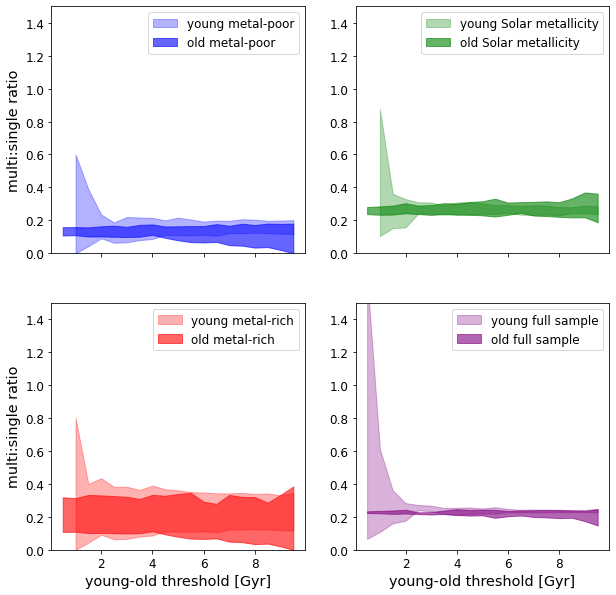

In [53]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10, 10), sharex=True)

ax1.fill_between(age_bin[:-1], poor_mins_young, poor_maxes_young, color='blue', alpha=0.3, label='young metal-poor')
ax1.fill_between(age_bin[:-1], poor_mins_old, poor_maxes_old, color='blue', alpha=0.6, label='old metal-poor')
ax1.set_ylabel('multi:single ratio')
#ax1.set_ylim([0, 0.5])
ax1.set_ylim([0, 1.5])
ax1.legend()

ax2.fill_between(age_bin[:-1], solar_mins_young, solar_maxes_young, color='green', alpha=0.3, label='young Solar metallicity')
ax2.fill_between(age_bin[:-1], solar_mins_old, solar_maxes_old, color='green', alpha=0.6, label='old Solar metallicity')
ax2.set_ylim([0, 1.5])
ax2.legend()

ax3.fill_between(age_bin[:-1], rich_mins_young, rich_maxes_young, color='red', alpha=0.3, label='young metal-rich')
ax3.fill_between(age_bin[:-1], rich_mins_old, rich_maxes_old, color='red', alpha=0.6, label='old metal-rich')
ax3.legend()
ax3.set_ylabel('multi:single ratio')
ax3.set_xlabel('young-old threshold [Gyr]')
ax3.set_ylim([0, 1.5])

ax4.fill_between(age_bin[:-1], mins_young, maxes_young, color='purple', alpha=0.3, label='young full sample')
ax4.fill_between(age_bin[:-1], mins_old, maxes_old, color='purple', alpha=0.6, label='old full sample')
ax4.legend()
ax4.set_xlabel('young-old threshold [Gyr]')
ax4.set_ylim([0, 1.5])

plt.legend()
#plt.savefig(path+'figures/multi-single-metallicity.png', facecolor='white', bbox_inches='tight')
plt.show()

In [28]:
len(poor), len(solar), len(rich), len(kepler_planet_enriched_temp)

(140, 336, 92, 568)

In [127]:
poor_fs = fs.loc[fs.feh_x < -0.25]
old_fs = fs.loc[fs.iso_age >= 4]
old_poor_fs = poor_fs.loc[poor_fs.iso_age >= 4]

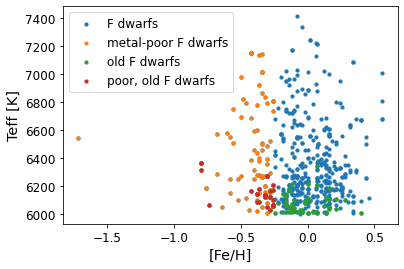

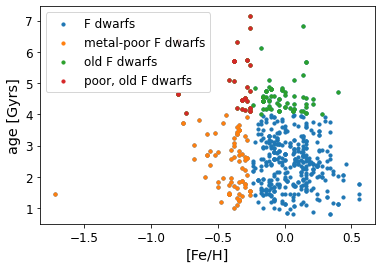

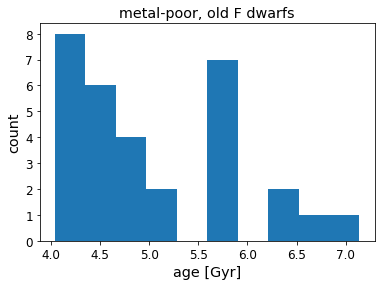

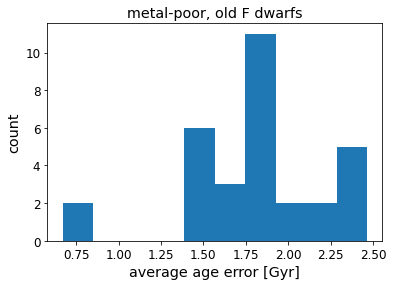

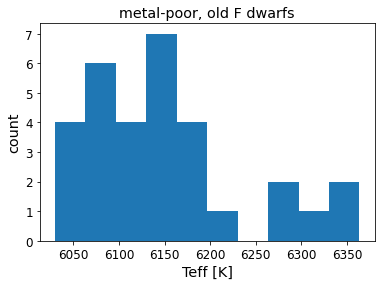

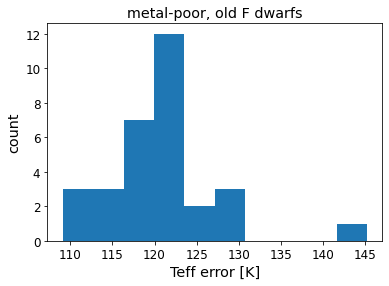

In [128]:
plt.scatter(fs.feh_x, fs.iso_teff, s=10, label='F dwarfs')
plt.scatter(poor_fs.feh_x, poor_fs.iso_teff, s=10, label='metal-poor F dwarfs')
plt.scatter(old_fs.feh_x, old_fs.iso_teff, s=10, label='old F dwarfs')
plt.scatter(old_poor_fs.feh_x, old_poor_fs.iso_teff, s=10, label='poor, old F dwarfs')
plt.ylabel('Teff [K]')
plt.xlabel('[Fe/H]')
#plt.xlim([-1, -0.25])
plt.legend()
plt.show()

plt.scatter(fs.feh_x, fs.iso_age, s=10, label='F dwarfs')
plt.scatter(poor_fs.feh_x, poor_fs.iso_age, s=10, label='metal-poor F dwarfs')
plt.scatter(old_fs.feh_x, old_fs.iso_age, s=10, label='old F dwarfs')
plt.scatter(old_poor_fs.feh_x, old_poor_fs.iso_age, s=10, label='poor, old F dwarfs')
plt.ylabel('age [Gyrs]')
plt.xlabel('[Fe/H]')
plt.legend()
plt.show()

plt.hist(old_poor_fs.iso_age)
plt.ylabel('count')
plt.xlabel('age [Gyr]')
plt.title('metal-poor, old F dwarfs')
plt.show()

plt.hist(0.5 * (old_poor_fs.iso_age_err1 + np.abs(old_poor_fs.iso_age_err2)))
plt.ylabel('count')
plt.xlabel('average age error [Gyr]')
plt.title('metal-poor, old F dwarfs')
plt.show()

plt.hist(old_poor_fs.iso_teff)
plt.ylabel('count')
plt.xlabel('Teff [K]')
plt.title('metal-poor, old F dwarfs')
plt.show()

plt.hist(0.5 * (old_poor_fs.iso_teff_err1 + np.abs(old_poor_fs.iso_teff_err2)))
plt.ylabel('count')
plt.xlabel('Teff error [K]')
plt.title('metal-poor, old F dwarfs')
plt.show()

#### For F dwarfs older than 4 Gyrs, how does multi:single ratio change with metallicity cut?

In [84]:
fe_bin = np.linspace(-0.5, 0.5, 11)

multi_singles_total_young = []
multi_singles_total_old = []

uniques = kepler_planet_enriched.drop_duplicates(subset=['kepid'])
uniques['iso_age_err'] = 0.5 * (uniques.iso_age_err1 + np.abs(uniques.iso_age_err2))
uniques['iso_teff_err'] = 0.5 * (uniques.iso_teff_err1 + np.abs(uniques.iso_teff_err2))

for i in range(50):
    
    multi_singles_young = []
    multi_singles_old = []
    multi_singles_poor_young = []
    multi_singles_poor_old = []
    multi_singles_solar_young = []
    multi_singles_solar_old = []
    multi_singles_rich_young = []
    multi_singles_rich_old = []
    
    # sample Teff, age, and metallicity values per star, assuming normally distributed errors
    uniques['age'] = np.random.normal(uniques.iso_age, uniques.iso_age_err)
    uniques['feh'] = np.random.normal(uniques.feh_x, uniques.feh_err)
    uniques['teffs'] = np.random.normal(uniques.iso_teff, uniques.iso_teff_err)

    kepler_planet_enriched_temp = uniques.merge(kepler_planet_enriched, on='kepid', how='right')
    kepler_planet_enriched_temp.age = kepler_planet_enriched_temp.age.fillna(method='ffill')
    kepler_planet_enriched_temp.feh = kepler_planet_enriched_temp.feh.fillna(method='ffill')
    kepler_planet_enriched_temp.teffs = kepler_planet_enriched_temp.teffs.fillna(method='ffill')
    
    # isolate just the F dwarfs
    kepler_planet_enriched_temp = kepler_planet_enriched_temp.loc[(kepler_planet_enriched_temp.teffs <= 7500) & (kepler_planet_enriched_temp.teffs > 6000)]
    kepler_planet_enriched_temp = kepler_planet_enriched_temp.loc[kepler_planet_enriched_temp.age >= 4]

    for j in fe_bin[:-1]:
        
        # isolate by age bin
        temp_poor = kepler_planet_enriched_temp.loc[kepler_planet_enriched_temp.feh <= j]
        temp_rich = kepler_planet_enriched_temp.loc[kepler_planet_enriched_temp.feh > j]
        # transiting planet distribution
        temp_planets_poor = temp_poor.groupby('kepid').count().reset_index().groupby('feh').count()
        temp_planets_rich = temp_rich.groupby('kepid').count().reset_index().groupby('feh').count()
        
        try:
            # singles
            singles_young = temp_planets_poor.kepid[1]
            singles_old = temp_planets_rich.kepid[1]
            # multis
            multis_young = temp_planets_poor.kepid.sum() - singles_young
            multis_old = temp_planets_rich.kepid.sum() - singles_old
            # ratio
            ratio_young = multis_young/singles_young  
            ratio_old = multis_old/singles_old  
            multi_singles_young.append(ratio_young)
            multi_singles_old.append(ratio_old)
        except:
            multi_singles_young.append(np.nan)
            multi_singles_old.append(np.nan)
        
    multi_singles_total_young.append(multi_singles_young)
    multi_singles_total_old.append(multi_singles_old)
    

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [90]:
mins_young = []
maxes_young = []

mins_old = []
maxes_old = []

medians_young = []
medians_old = []

for i in range(len(fe_bin[:-1])):
    # young  
    mins_young.append(np.amin(np.take(multi_singles_total_young, indices=i, axis=1)))
    maxes_young.append(np.amax(np.take(multi_singles_total_young, indices=i, axis=1)))
    medians_young.append(np.median(np.take(multi_singles_total_young, indices=i, axis=1)))

    # old    
    mins_old.append(np.amin(np.take(multi_singles_total_old, indices=i, axis=1)))
    maxes_old.append(np.amax(np.take(multi_singles_total_old, indices=i, axis=1)))
    medians_old.append(np.median(np.take(multi_singles_total_old, indices=i, axis=1)))
    

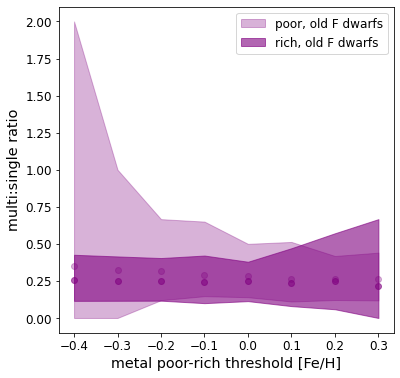

In [91]:
fig, ((ax1)) = plt.subplots(1,1, figsize=(6, 6), sharex=True)

ax1.fill_between(fe_bin[:-1], mins_young, maxes_young, color='purple', alpha=0.3, label='poor, old F dwarfs')
ax1.fill_between(fe_bin[:-1], mins_old, maxes_old, color='purple', alpha=0.6, label='rich, old F dwarfs')
ax1.scatter(fe_bin[:-1], medians_young, color='purple', alpha=0.3)
ax1.scatter(fe_bin[:-1], medians_old, color='purple', alpha=0.6)

ax1.legend()
ax1.set_xlabel('metal poor-rich threshold [Fe/H]')
#ax1.set_ylim([0, 1.5])

plt.legend()
#plt.savefig(path+'figures/multi-single-metallicity.pdf', format='pdf')
plt.ylabel('multi:single ratio')
plt.show()

And for G dwarfs...

In [122]:
age_bin = np.linspace(0.5, 10, 20)

multi_singles_total_young = []
multi_singles_total_old = []
multi_singles_poor_total_young = []
multi_singles_solar_total_young = []
multi_singles_rich_total_young = []
multi_singles_poor_total_old = []
multi_singles_solar_total_old = []
multi_singles_rich_total_old = []

uniques = kepler_planet_enriched.drop_duplicates(subset=['kepid'])
uniques['iso_age_err'] = 0.5 * (uniques.iso_age_err1 + np.abs(uniques.iso_age_err2))
uniques['iso_teff_err'] = 0.5 * (uniques.iso_teff_err1 + np.abs(uniques.iso_teff_err2))

for i in range(10):
    
    multi_singles_young = []
    multi_singles_old = []
    multi_singles_poor_young = []
    multi_singles_poor_old = []
    multi_singles_solar_young = []
    multi_singles_solar_old = []
    multi_singles_rich_young = []
    multi_singles_rich_old = []
    
    # sample Teff, age, and metallicity values per star, assuming normally distributed errors
    uniques['age'] = np.random.normal(uniques.iso_age, uniques.iso_age_err)
    uniques['feh'] = np.random.normal(uniques.feh_x, uniques.feh_err)
    uniques['teffs'] = np.random.normal(uniques.iso_teff, uniques.iso_teff_err)

    kepler_planet_enriched_temp = uniques.merge(kepler_planet_enriched, on='kepid', how='right')
    kepler_planet_enriched_temp.age = kepler_planet_enriched_temp.age.fillna(method='ffill')
    kepler_planet_enriched_temp.feh = kepler_planet_enriched_temp.feh.fillna(method='ffill')
    kepler_planet_enriched_temp.teffs = kepler_planet_enriched_temp.teffs.fillna(method='ffill')
    
    # isolate just the F dwarfs
    kepler_planet_enriched_temp = kepler_planet_enriched_temp.loc[(kepler_planet_enriched_temp.teffs <= 6000) & (kepler_planet_enriched_temp.teffs > 5300)]
    
    # isolate by metallicity
    poor = kepler_planet_enriched_temp.loc[kepler_planet_enriched_temp.feh < -0.25]
    solar = kepler_planet_enriched_temp.loc[(kepler_planet_enriched_temp.feh >= -0.25) & (kepler_planet_enriched_temp.feh <= 0.25)]
    rich = kepler_planet_enriched_temp.loc[kepler_planet_enriched_temp.feh > 0.25]
    
    for j in age_bin[:-1]:
        
        # isolate by age bin
        temp_young = kepler_planet_enriched_temp.loc[kepler_planet_enriched_temp.age <= j]
        temp_old = kepler_planet_enriched_temp.loc[kepler_planet_enriched_temp.age > j]
        # transiting planet distribution
        temp_planets_young = temp_young.groupby('kepid').count().reset_index().groupby('age').count()
        temp_planets_old = temp_old.groupby('kepid').count().reset_index().groupby('age').count()
        # compute multi-single ratios for young and old samples
        try:
            singles_young = temp_planets_young.kepid[1]
            multis_young = temp_planets_young.kepid.sum() - singles_young
            ratio_young = multis_young/singles_young  
        except:
            ratio_young = np.nan
        
        try:
            singles_old = temp_planets_old.kepid[1]
            multis_old = temp_planets_old.kepid.sum() - singles_old
            ratio_old = multis_old/singles_old  
        except:
            ratio_old = np.nan
            
        multi_singles_young.append(ratio_young)
        multi_singles_old.append(ratio_old)
        
        
        ### now do this for different metallicity bins
        temp_poor_young = poor.loc[poor.age <= j]
        temp_poor_old = poor.loc[poor.age > j]
        temp_solar_young = solar.loc[solar.age <= j]
        temp_solar_old = solar.loc[solar.age > j]
        temp_rich_young = rich.loc[rich.age <= j]
        temp_rich_old = rich.loc[rich.age > j]
        # transiting planet distribution
        temp_poor_planets_young = temp_poor_young.groupby('kepid').count().reset_index().groupby('age').count()
        temp_poor_planets_old = temp_poor_old.groupby('kepid').count().reset_index().groupby('age').count()
        temp_solar_planets_young = temp_solar_young.groupby('kepid').count().reset_index().groupby('age').count()
        temp_solar_planets_old = temp_solar_old.groupby('kepid').count().reset_index().groupby('age').count()
        temp_rich_planets_young = temp_rich_young.groupby('kepid').count().reset_index().groupby('age').count()
        temp_rich_planets_old = temp_rich_old.groupby('kepid').count().reset_index().groupby('age').count()
        
        # calculate multi:single ratios
        try:
            singles_poor_young = temp_poor_planets_young.kepid[1]
            multis_poor_young = temp_poor_planets_young.kepid.sum() - singles_poor_young
            ratio_poor_young = multis_poor_young/singles_poor_young   
            
        except:
            ratio_poor_young = np.nan
            
        try:
            singles_poor_old = temp_poor_planets_old.kepid[1]
            multis_poor_old = temp_poor_planets_old.kepid.sum() - singles_poor_old
            ratio_poor_old = multis_poor_old/singles_poor_old
        except:
            ratio_poor_old = np.nan
            
        try:
            singles_solar_young = temp_solar_planets_young.kepid[1]
            multis_solar_young = temp_solar_planets_young.kepid.sum() - singles_solar_young
            ratio_solar_young = multis_solar_young/singles_solar_young
        except:
            ratio_solar_young = np.nan
            
        try:
            singles_solar_old = temp_solar_planets_old.kepid[1]
            multis_solar_old = temp_solar_planets_old.kepid.sum() - singles_solar_old
            ratio_solar_old = multis_solar_old/singles_solar_old
        except:
            ratio_solar_old = np.nan
        
        try:
            singles_rich_young = temp_rich_planets_young.kepid[1]
            multis_rich_young = temp_rich_planets_young.kepid.sum() - singles_rich_young
            ratio_rich_young = multis_rich_young/singles_rich_young
        except:
            ratio_rich_young = np.nan
            
        try:
            singles_rich_old = temp_rich_planets_old.kepid[1]
            multis_rich_old = temp_rich_planets_old.kepid.sum() - singles_rich_old
            ratio_rich_old = multis_rich_old/singles_rich_old
        except:
            ratio_rich_old = np.nan
            
        multi_singles_poor_young.append(ratio_poor_young)
        multi_singles_poor_old.append(ratio_poor_old)
        multi_singles_solar_young.append(ratio_solar_young)
        multi_singles_solar_old.append(ratio_solar_old)
        multi_singles_rich_young.append(ratio_rich_young)
        multi_singles_rich_old.append(ratio_rich_old)
        
    multi_singles_total_young.append(multi_singles_young)
    multi_singles_total_old.append(multi_singles_old)
    multi_singles_poor_total_young.append(multi_singles_poor_young)
    multi_singles_poor_total_old.append(multi_singles_poor_old)
    multi_singles_solar_total_young.append(multi_singles_solar_young)
    multi_singles_solar_total_old.append(multi_singles_solar_old)
    multi_singles_rich_total_young.append(multi_singles_rich_young)
    multi_singles_rich_total_old.append(multi_singles_rich_old)
    

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [123]:
mins_young = []
maxes_young = []
poor_mins_young = []
solar_mins_young = []
rich_mins_young = []
poor_maxes_young = []
solar_maxes_young = []
rich_maxes_young = []

mins_old = []
maxes_old = []
poor_mins_old = []
solar_mins_old = []
rich_mins_old = []
poor_maxes_old = []
solar_maxes_old = []
rich_maxes_old = []

for i in range(len(age_bin[:-1])):
    # young
    poor_mins_young.append(np.amin(np.take(multi_singles_poor_total_young, indices=i, axis=1)))
    poor_maxes_young.append(np.amax(np.take(multi_singles_poor_total_young, indices=i, axis=1)))
    
    solar_mins_young.append(np.amin(np.take(multi_singles_solar_total_young, indices=i, axis=1)))
    solar_maxes_young.append(np.amax(np.take(multi_singles_solar_total_young, indices=i, axis=1)))
    
    rich_mins_young.append(np.amin(np.take(multi_singles_poor_total_young, indices=i, axis=1)))
    rich_maxes_young.append(np.amax(np.take(multi_singles_rich_total_young, indices=i, axis=1)))
    
    mins_young.append(np.amin(np.take(multi_singles_total_young, indices=i, axis=1)))
    maxes_young.append(np.amax(np.take(multi_singles_total_young, indices=i, axis=1)))
    
    # old
    poor_mins_old.append(np.amin(np.take(multi_singles_poor_total_old, indices=i, axis=1)))
    poor_maxes_old.append(np.amax(np.take(multi_singles_poor_total_old, indices=i, axis=1)))
    
    solar_mins_old.append(np.amin(np.take(multi_singles_solar_total_old, indices=i, axis=1)))
    solar_maxes_old.append(np.amax(np.take(multi_singles_solar_total_old, indices=i, axis=1)))
    
    rich_mins_old.append(np.amin(np.take(multi_singles_poor_total_old, indices=i, axis=1)))
    rich_maxes_old.append(np.amax(np.take(multi_singles_rich_total_old, indices=i, axis=1)))
    
    mins_old.append(np.amin(np.take(multi_singles_total_old, indices=i, axis=1)))
    maxes_old.append(np.amax(np.take(multi_singles_total_old, indices=i, axis=1)))
    

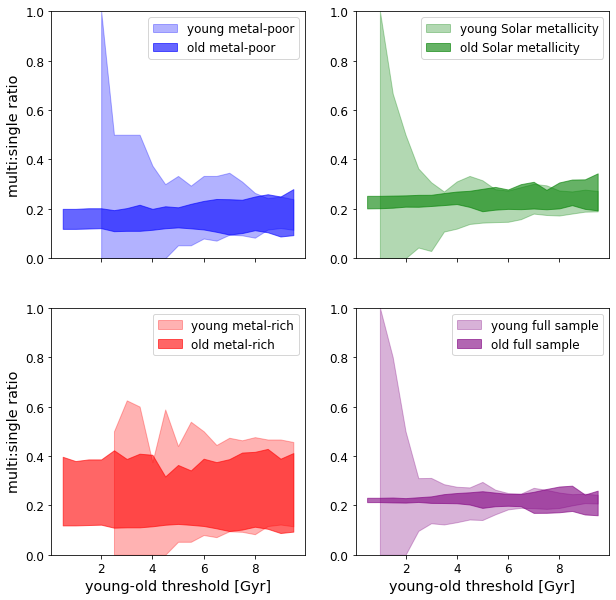

In [124]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10, 10), sharex=True)

ax1.fill_between(age_bin[:-1], poor_mins_young, poor_maxes_young, color='blue', alpha=0.3, label='young metal-poor')
ax1.fill_between(age_bin[:-1], poor_mins_old, poor_maxes_old, color='blue', alpha=0.6, label='old metal-poor')
ax1.set_ylabel('multi:single ratio')
ax1.set_ylim([0, 1])
ax1.legend()

ax2.fill_between(age_bin[:-1], solar_mins_young, solar_maxes_young, color='green', alpha=0.3, label='young Solar metallicity')
ax2.fill_between(age_bin[:-1], solar_mins_old, solar_maxes_old, color='green', alpha=0.6, label='old Solar metallicity')
ax2.legend()
ax2.set_ylim([0, 1])

ax3.fill_between(age_bin[:-1], rich_mins_young, rich_maxes_young, color='red', alpha=0.3, label='young metal-rich')
ax3.fill_between(age_bin[:-1], rich_mins_old, rich_maxes_old, color='red', alpha=0.6, label='old metal-rich')
ax3.legend()
ax3.set_ylabel('multi:single ratio')
ax3.set_xlabel('young-old threshold [Gyr]')
ax3.set_ylim([0, 1])

ax4.fill_between(age_bin[:-1], mins_young, maxes_young, color='purple', alpha=0.3, label='young full sample')
ax4.fill_between(age_bin[:-1], mins_old, maxes_old, color='purple', alpha=0.6, label='old full sample')
ax4.legend()
ax4.set_xlabel('young-old threshold [Gyr]')
ax4.set_ylim([0, 1])

plt.legend()
#plt.savefig(path+'figures/multi-single-metallicity.pdf', format='pdf')
plt.show()

In [58]:
len(poor), len(solar), len(rich), len(kepler_planet_enriched_temp)

(149, 400, 120, 669)

In [59]:
len(fs), len(gs)

(556, 704)